In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime, timezone
from pathlib import Path

plt.style.use("ggplot")

#  Harmonize and Export River Water Chemistry Data

This notebook performs reconstruction, calculation, quality control, and export of river water chemistry data derived from NIVA’s database. It processes NetCDF datasets, computes derived parameters, filters outliers, attaches CF-compliant metadata, and exports the results as standardized NetCDF files.

### How to run the analysis?
1. Clone the AquaINFRA GitHub repo
2. Make sure the following dependencies are installed in the environment: xarray, pandas, numpy, matplotlib, pathlib
3. Define input files, metadata, and output files.
4. Run all cells sequentially.

### Which programming languages are used?
- Python

### How does the workflow look like?
1. Read raw NetCDF files
2. Convert to pandas DataFrames
3. Reconstruct missing values
4. Compute derived parameters
5. Visualize original vs derived variables
6. Apply outlier filtering using percentile thresholds
7. Convert to xarray.Dataset and assign time + station coordinates
8. Attach variable and global metadata
9. Export NetCDF files 

### Which functions are used and how are they connected?
- `plot_reconstruction()` – Plots original vs reconstructed variables
- `plot_scatter()` – Compares calculated vs observed values
- `plot_lines()` – Plots time series
- `detect_outliers_per_station()` – Identifies and replaces outliers using 0.05–99 percentile filtering
- `xr.Dataset.from_dataframe()` – Converts cleaned DataFrames to xarray.Dataset
- `to_netcdf()` – Saves final datasets with CF/ACDD metadata to NetCDF format


## 0. User inputs

In [2]:
# Define input files 
wc_raw_data_dir = Path("../../data/river/water_chemistry/raw")
wc_raw_data_file_paths = list(wc_raw_data_dir.glob("raw_riverchem_*.nc"))

# Parameters metadata
pars_metadata_df = pd.DataFrame({
    "parameter_name": ["DOC", "Color", "NH4-N", "NO3-N", "TRP", "POC", "POC_calc", "TOC_calc", "SPM", "SiO2", "TOC", "TOTN", "TOTP", "TDP", "DIN", 
                       "DON", "PP", "TSM", "UV_Abs_254nm", "UV_Abs_410nm"],
    "unit":  ["mg/l C", "mg Pt/l", "µg/l", "µg/l", "µg/l", "mg/l", "mg/l", "mg/l", "mg/l", "mg/l", "mg/l", "µg/l", "µg/l", "µg/l P", "µg/l", 
              "µg/l", "µg/l P", "mg/l", "Abs/cm", "Abs/cm"]
})

# Define a mapping from parameter names to long names
standard_name_map = {
    "DOC": "Dissolved Organic Carbon",
    "Color": "Water Color",
    "NH4-N": "Ammonium-N",
    "NO3-N": "Nitrate-N",
    "TRP": "Total Reactive Phosphorus",
    "POC": "Particulate Organic Carbon",
    "POC_calc": "Particulate Organic Carbon Calculated",
    "TOC_calc": "Total Organic Carbon Calculated",
    "SPM": "Suspended Particulate Matter", 
    "SiO2": "Silicate", 
    "TOC": "Total Organic Carbon",
    "TOTN": "Total Nitrogen",
    "TOTP": "Total Phosphorus",
    "TDP": "Total Dissolved Phosphorus",
    "DIN": "Dissolved Inorganic Nitrogen",
    "DON": "Dissolved Organic Nitrogen",
    "PP": "Particulate Phosphorus",
    "TSM": "Total Suspended Matter",
    "UV_Abs_254nm": "Ultraviolet Absorbance 254nm",
    "UV_Abs_410nm": "Ultraviolet Absorbance 410nm",
}

# Comments for selected variables
var_comments = {
    "TOTN": "TOTN is reconstructed using Eurofins data (TOTN_EF_usikker), which are considered more uncertain than NIVA data. However, due to gaps in NIVA data from 2017–2021, Eurofins measurements were included to ensure completeness.",
    "SiO2": "SiO2 is reconstructed from Si using a conversion factor of 2.14 (based on molecular weights). Different methods were used (photometric vs ICP-MS), but results are expected to be comparable.",
    "TOC_calc": "TOC_calc is computed as POC + DOC, for comparison with lab-reported TOC. It is often more accurate due to rounding errors and turbidity effects in TOC analysis.",
    "DIN": "DIN is calculated as NO3-N + NH4-N, only when both values are available.",
    "DON": "DON is calculated as TOTN - DIN, only where both TOTN and DIN are available.",
    "PP": "PP is computed as TOTP - TDP for the period 2017–2020.",
    "TDP": "TDP is computed as TOTP - PP for the period 2021–2024.",
    "TRP": "TRP includes both Soluble Reactive Phosphorus (SRP) and Particulate Reactive Phosphorus (PRP) fractions.",
    "SPM": "SPM is measured using xxx filters.",
    "TSM": "TSM is measured using xx filters."
}

# Where to save 
output_dir = Path("../../data/river/water_chemistry/cleaned")
output_dir.mkdir(parents=True, exist_ok=True)

## 1. Load data

In [3]:
initial_dataframes = []
for fp in wc_raw_data_file_paths:
    ds = xr.open_dataset(fp)
    df = ds.to_dataframe().reset_index() # Convert to dataframes for easier analysis
    
    # Make sure date is datetime
    if "sample_date" in df.columns:
        df["sample_date"] = pd.to_datetime(df["sample_date"], errors="coerce")
    elif "time" in df.columns:
        df["time"] = pd.to_datetime(df["time"], errors="coerce")

    initial_dataframes.append((fp.name, df))

## 2. Reconstruct TOTN and SiO2 time series 

In [4]:
def plot_reconstruction(df, date_col, var_orig, var_final,
                        label_base="", station_label="", units="", colors=None):
    colors = colors or {'original': '#1b9e77', 'final': '#d95f02'}

    if var_orig not in df.columns or var_final not in df.columns:
        return  # skip if either column is missing

    plt.figure(figsize=(10, 4))
    plt.plot(df[date_col], df[var_orig], label=f'{label_base} (original)',
             color=colors['original'], marker='o', linestyle='none')
    plt.plot(df[date_col], df[var_final], label=f'{label_base} (reconstructed)',
             color=colors['final'], marker='.', linestyle='-', alpha=0.7)
    plt.title(f"{station_label}")
    plt.ylabel(f"{label_base} ({units})" if units else label_base)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

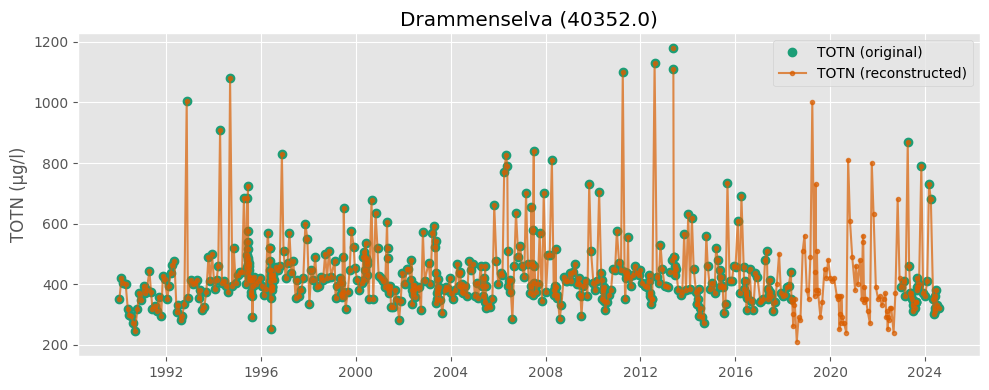

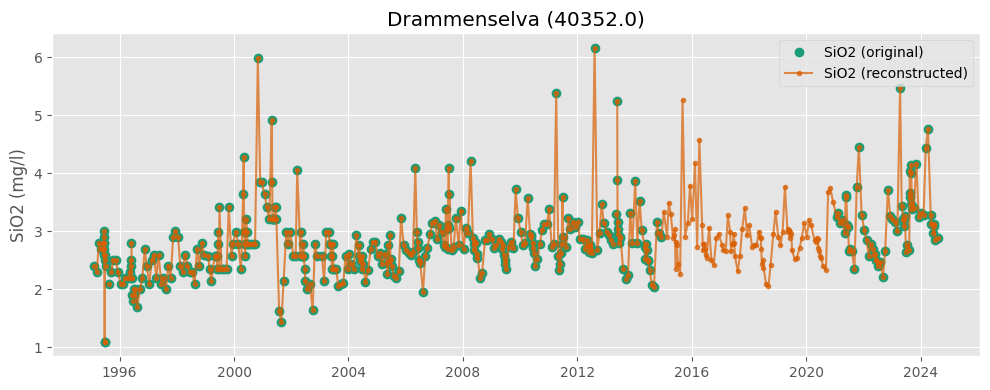

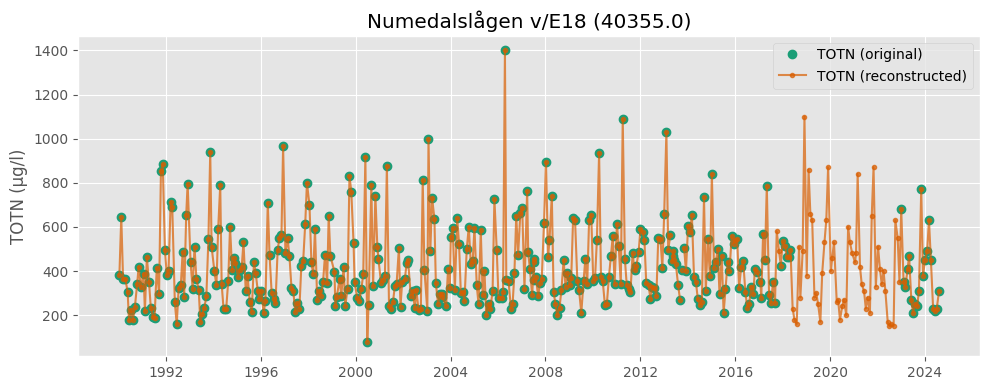

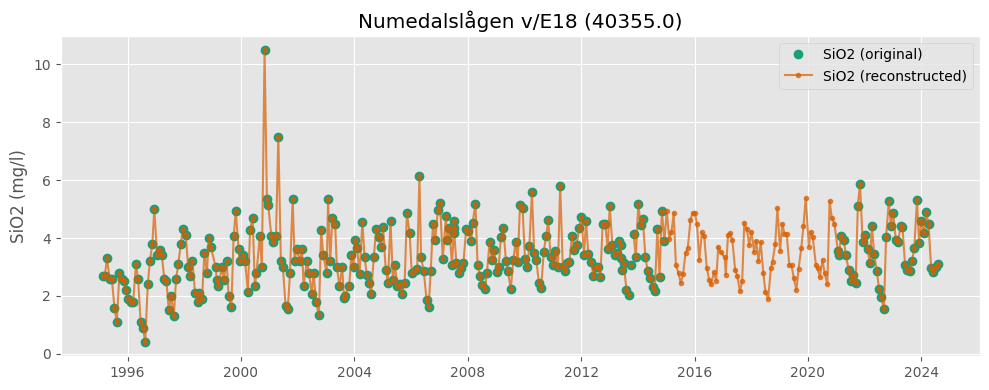

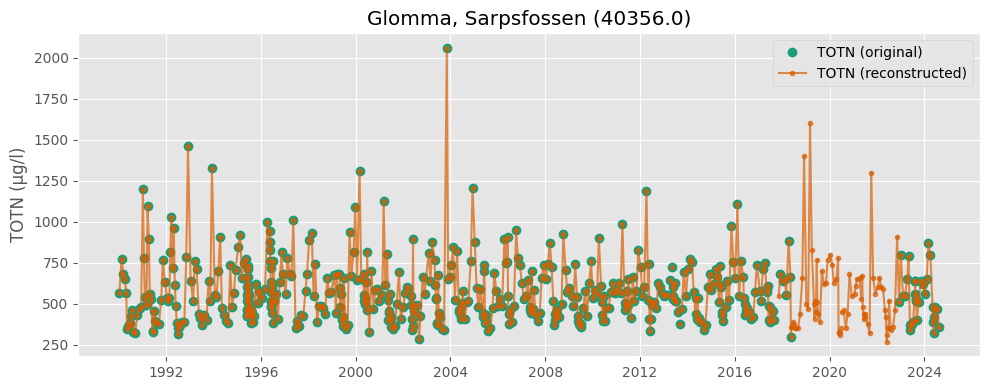

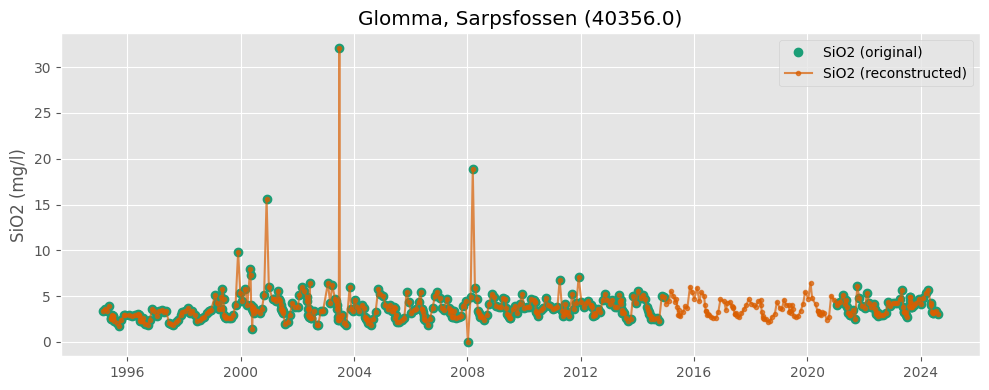

In [5]:
reconstructed_dataframes = []

for fname, df in initial_dataframes:
    df = df.copy()
    date_col = "sample_date" if "sample_date" in df.columns else None
    if not date_col:
        continue

    # Station info
    station_name = df['station_name'].dropna().unique()
    station_id = df['station_id'].dropna().unique()
    station_str = station_name[0] if len(station_name) > 0 else fname
    station_id_str = f" ({station_id[0]})" if len(station_id) > 0 else ""
    station_label = f"{station_str}{station_id_str}"

    # Preserve original TOTN and SiO2 before overwriting
    if 'TOTN' in df.columns:
        df['TOTN_orig'] = df['TOTN']
    if 'SiO2' in df.columns:
        df['SiO2_orig'] = df['SiO2']

    # Reconstruct TOTN
    if 'TOTN' in df.columns and 'TOTN_EF_usikker' in df.columns:
        df['TOTN'] = df['TOTN'].fillna(df['TOTN_EF_usikker'])

    # Reconstruct SiO2
    if 'Si' in df.columns:
        df['SiO2_calc'] = df['Si'] * 2.14
        if 'SiO2' in df.columns:
            df['SiO2'] = df['SiO2'].fillna(df['SiO2_calc'])
        else:
            df['SiO2'] = df['SiO2_calc']

    # Plot original and final 
    if 'TOTN_orig' in df.columns and 'TOTN' in df.columns:
        plot_reconstruction(df, date_col, 'TOTN_orig', 'TOTN',
                            label_base='TOTN', station_label=station_label, units='µg/l')

    if 'SiO2_orig' in df.columns and 'SiO2' in df.columns:
        plot_reconstruction(df, date_col, 'SiO2_orig', 'SiO2',
                            label_base='SiO2', station_label=station_label, units='mg/l')

    # Drop intermediate columns
    cols_to_drop = [col for col in ['TOTN_EF_usikker', 'Si', 'SiO2_calc', 'TOTN_orig', 'SiO2_orig']
                    if col in df.columns]
    df = df.drop(columns=cols_to_drop)

    reconstructed_dataframes.append((fname, df))

## 3. Compute derived parameters

In [6]:
derived_dataframes = []

for fname, df in reconstructed_dataframes:
    df = df.copy()
    
    # Convert POC from µg/l to mg/l and retain the name
    if 'POC' in df.columns:
        df['POC'] = df['POC'] / 1000 

    # Compute TOC using POC and DOC (TOC calculated)
    if 'POC' in df.columns and 'DOC' in df.columns:
        df['TOC_calc'] = df['POC'] + df['DOC']

    # Fill missing phosphorus species
    if all(col in df.columns for col in ['TDP', 'PP', 'TOTP']):
        df.loc[
            df['TDP'].isna() & df['PP'].notna(),
            'TDP'
        ] = df['TOTP'] - df['PP']

        df.loc[
            df['PP'].isna() & df['TDP'].notna(),
            'PP'
        ] = df['TOTP'] - df['TDP']

    # Compute DIN using NO3 and NH4 
    if 'NO3-N' in df.columns and 'NH4-N' in df.columns:
        df['DIN'] = df.apply(
            lambda row: row['NO3-N'] + row['NH4-N']
            if pd.notna(row['NO3-N']) and pd.notna(row['NH4-N']) else np.nan,
            axis=1
        )

    # Compute DON using TOTN and DIN
    if 'TOTN' in df.columns and 'DIN' in df.columns:
        df['DON'] = df['TOTN'] - df['DIN']

     # Special case: for file containing '40355', set TOC = NaN before 1998-01-01
    if '40355' in fname and 'TOC' in df.columns and 'sample_date' in df.columns:
        df.loc[pd.to_datetime(df['sample_date']) < pd.Timestamp("1998-01-01"), 'TOC'] = np.nan

    derived_dataframes.append((fname, df))

In [7]:
def plot_scatter(ax, x, y, xlabel, ylabel, title, unit=None):
    ax.scatter(x, y, alpha=0.5)
    if pd.notna(x).any() and pd.notna(y).any():
        lims = [min(x.min(), y.min()), max(x.max(), y.max())]
        ax.plot(lims, lims, 'r--')

    unit_str = f" ({unit})" if unit else ""
    ax.set_xlabel(f"{xlabel}{unit_str}")
    ax.set_ylabel(f"{ylabel}{unit_str}")
    ax.set_title(title)

def plot_lines(ax, df, columns, labels, title, unit=None):
    for col, label in zip(columns, labels):
        if col in df.columns:
            ax.plot(df['sample_date'], df[col], label=label)
    ax.legend()
    ax.set_title(title)
    if unit:
        ax.set_ylabel(f'{unit}')
    else:
        ax.set_ylabel('##')

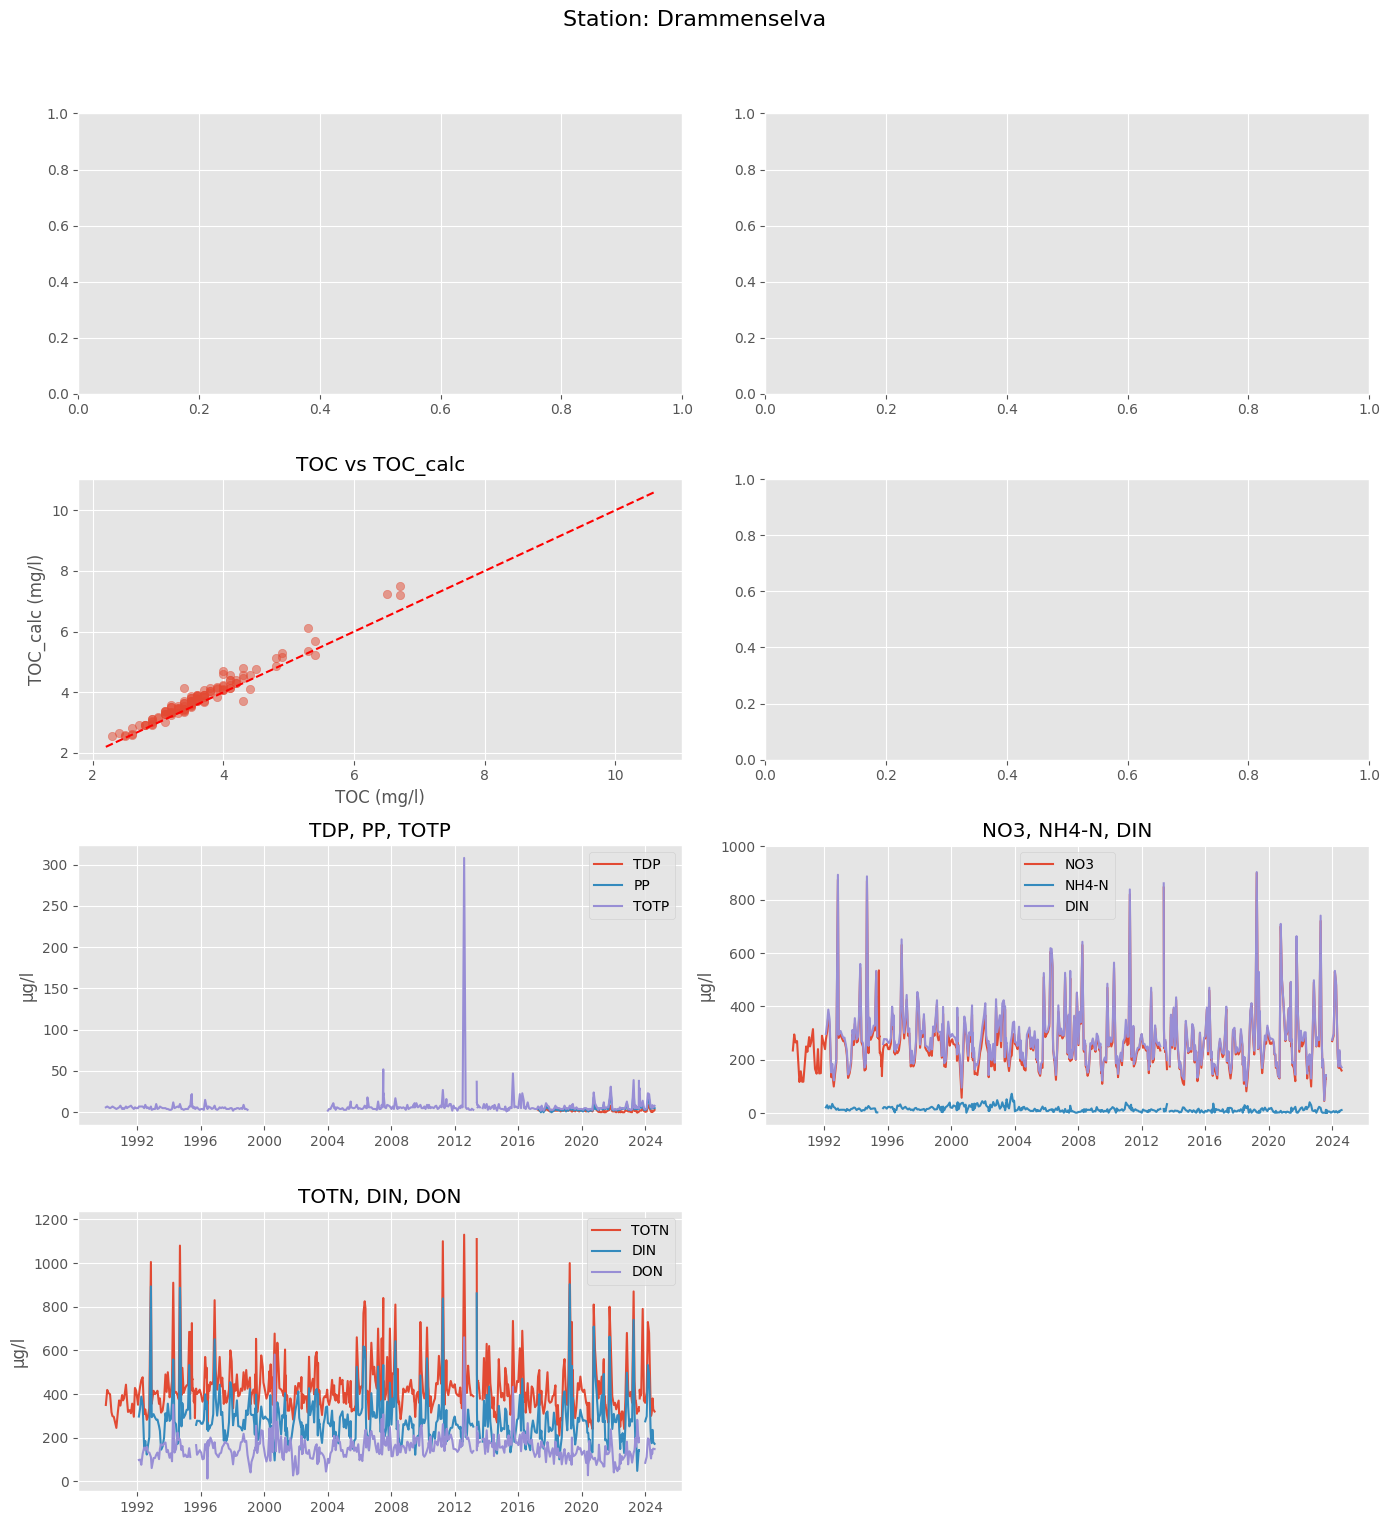

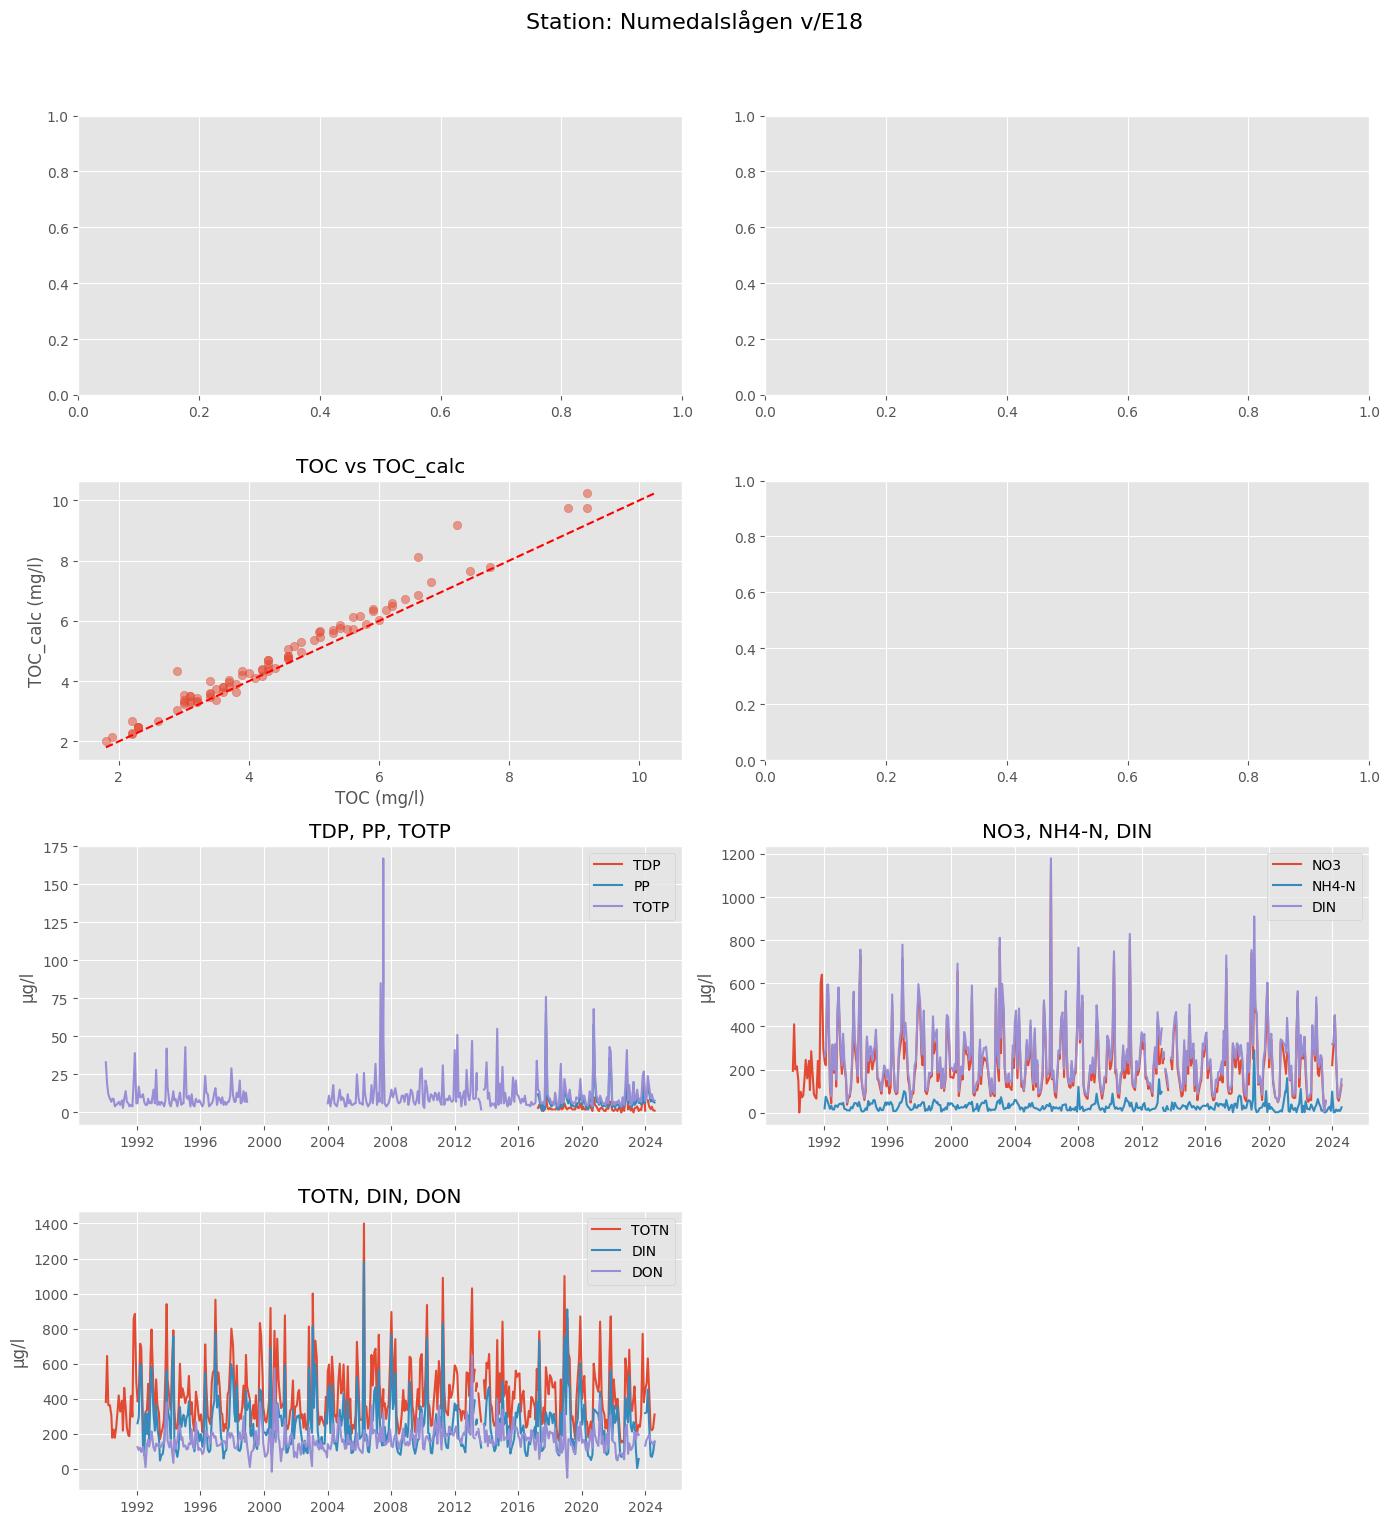

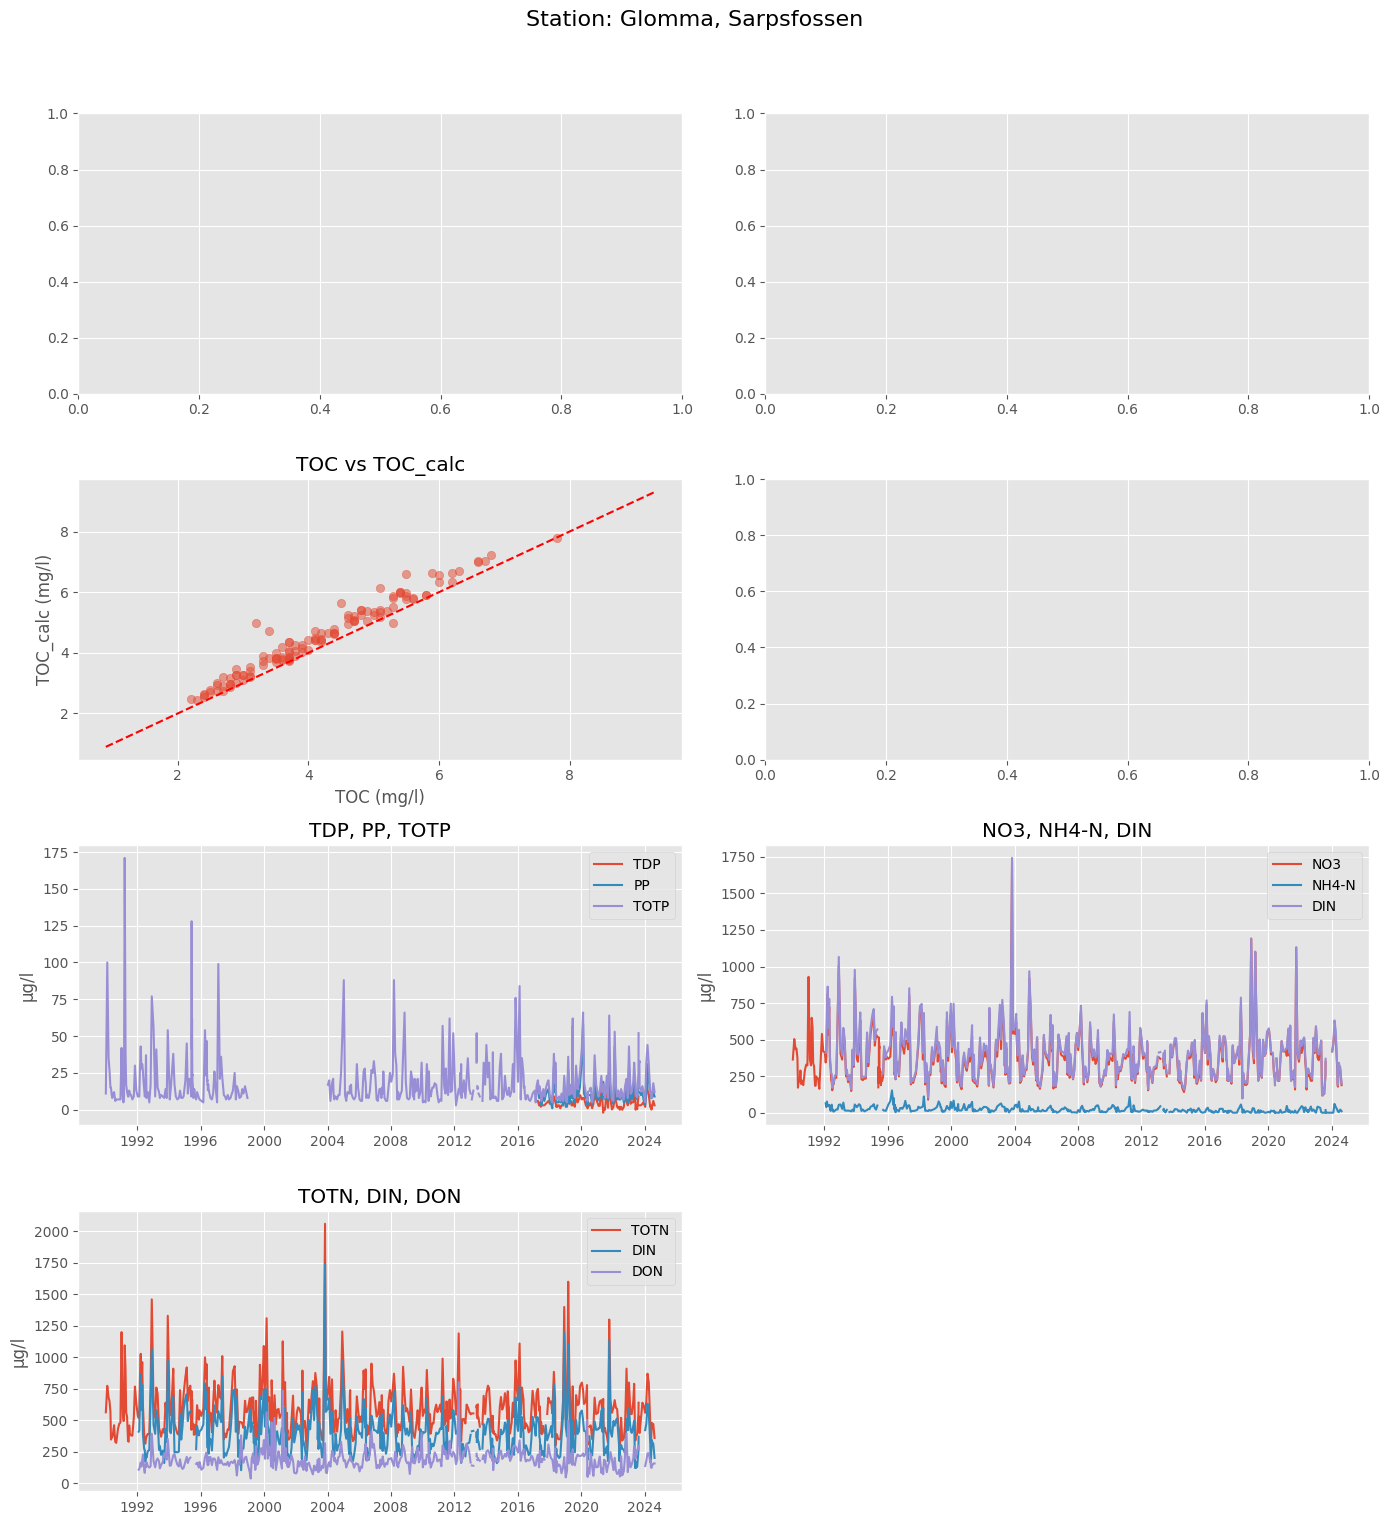

In [8]:
for fname, df in derived_dataframes:
    station = df['station_name'].dropna().unique()
    title = station[0] if len(station) else fname

    fig, axs = plt.subplots(4, 2, figsize=(14, 16))
    fig.suptitle(f"Station: {title}", fontsize=16)

    # TOC vs TOC_calc
    if {'TOC', 'TOC_calc'}.issubset(df.columns):
        plot_scatter(axs[1, 0], df['TOC'], df['TOC_calc'], 'TOC', 'TOC_calc', 'TOC vs TOC_calc', unit='mg/l')

    # TOC, DOC, POC, POC_calc
    if all(col in df.columns for col in ['TOC', 'DOC', 'POC', 'POC_calc']):
        plot_lines(axs[1, 1], df, ['TOC', 'DOC', 'POC', 'POC_calc'], ['TOC', 'DOC', 'POC', 'POC_calc'], 'TOC, DOC, POC, POC_calc', unit='mg/l')

    # TDP, PP, and TOTP 
    if all(col in df.columns for col in ['TDP', 'PP', 'TOTP']):
        plot_lines(axs[2, 0], df, ['TDP', 'PP', 'TOTP'], ['TDP', 'PP', 'TOTP'], 'TDP, PP, TOTP', unit='µg/l')

    # NO3, NH4, and DIN
    if all(col in df.columns for col in ['NO3-N', 'NH4-N', 'DIN']):
        plot_lines(axs[2, 1], df, ['NO3-N', 'NH4-N', 'DIN'], ['NO3', 'NH4-N', 'DIN'], 'NO3, NH4-N, DIN', unit='µg/l')

    # TOTN, DIN, and DON
    if all(col in df.columns for col in ['TOTN', 'DIN', 'DON']):
        plot_lines(axs[3, 0], df, ['TOTN', 'DIN', 'DON'], ['TOTN', 'DIN', 'DON'], 'TOTN, DIN, DON', unit='µg/l')

    axs[3, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 4. Outlier removal

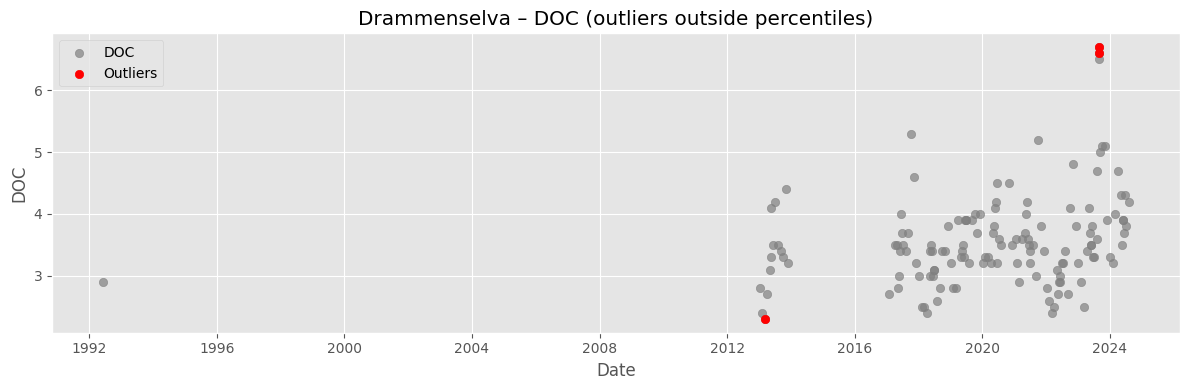

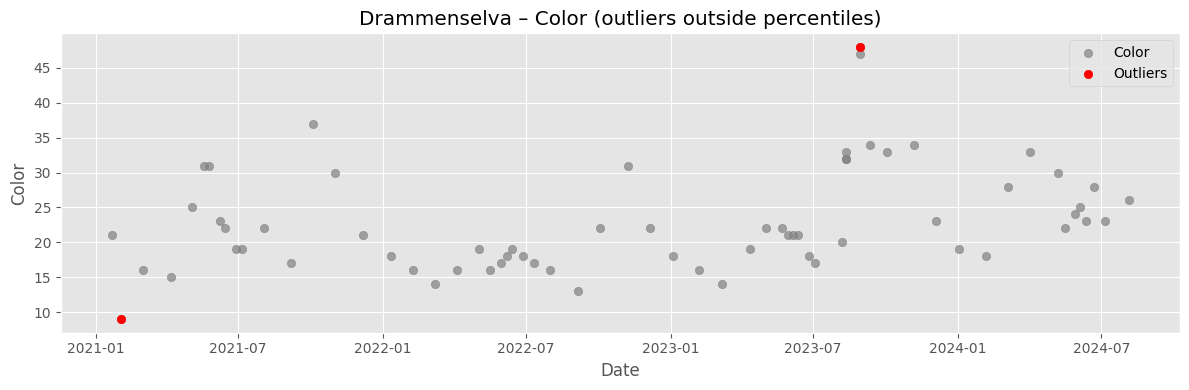

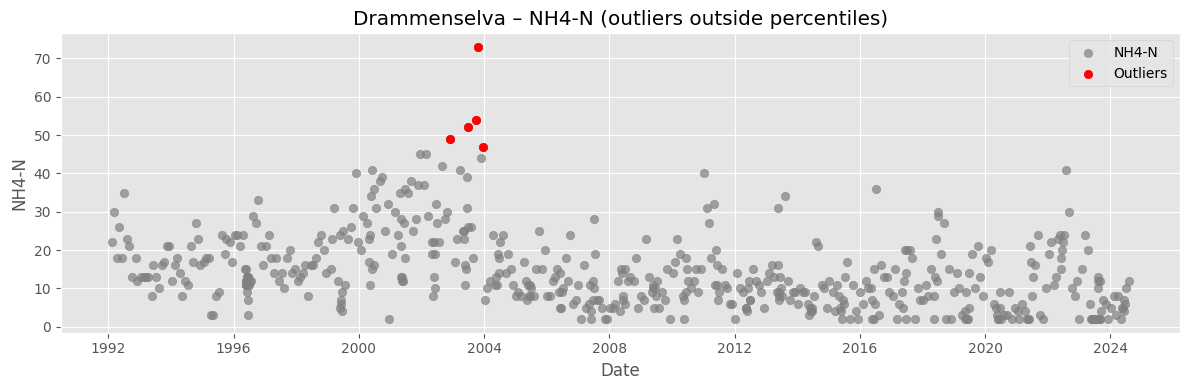

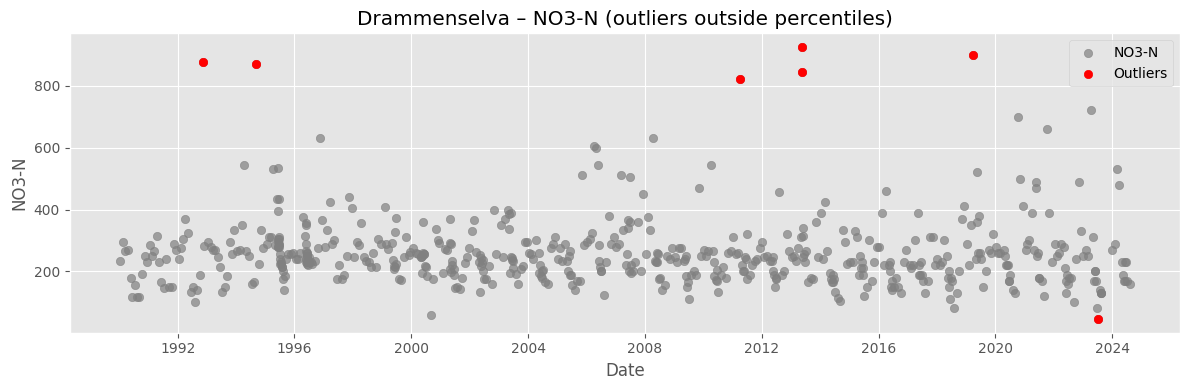

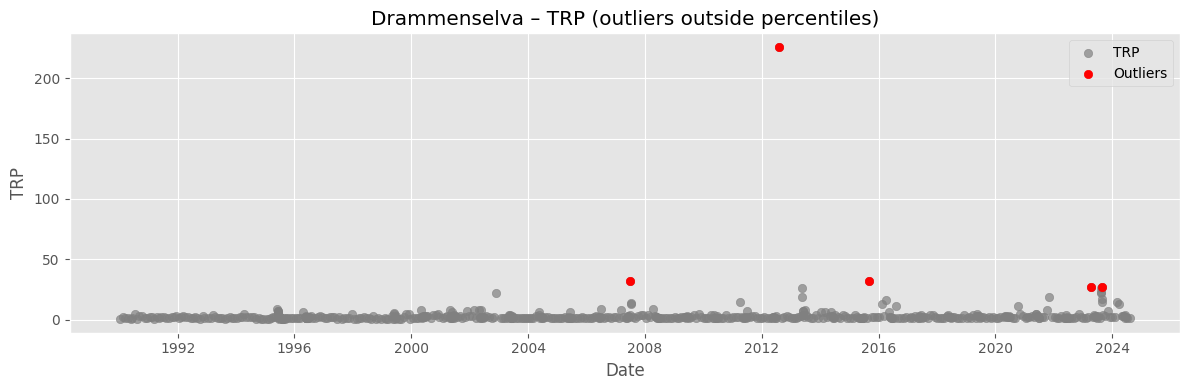

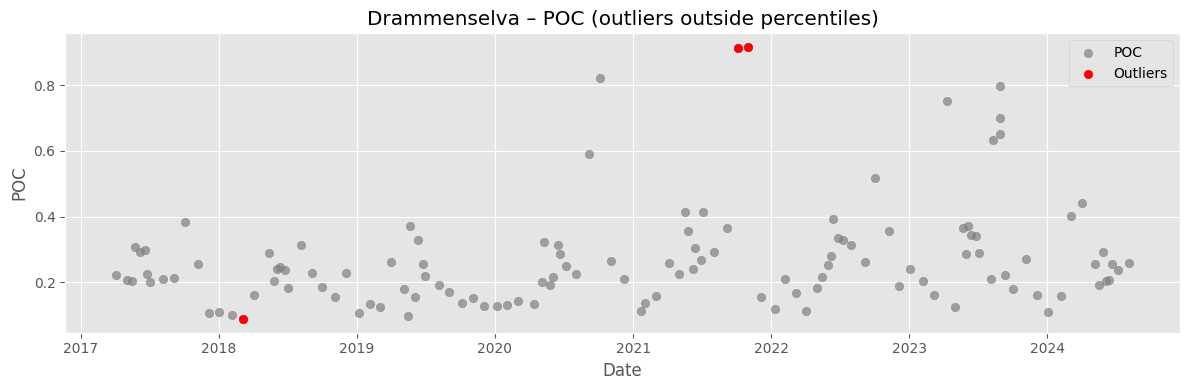

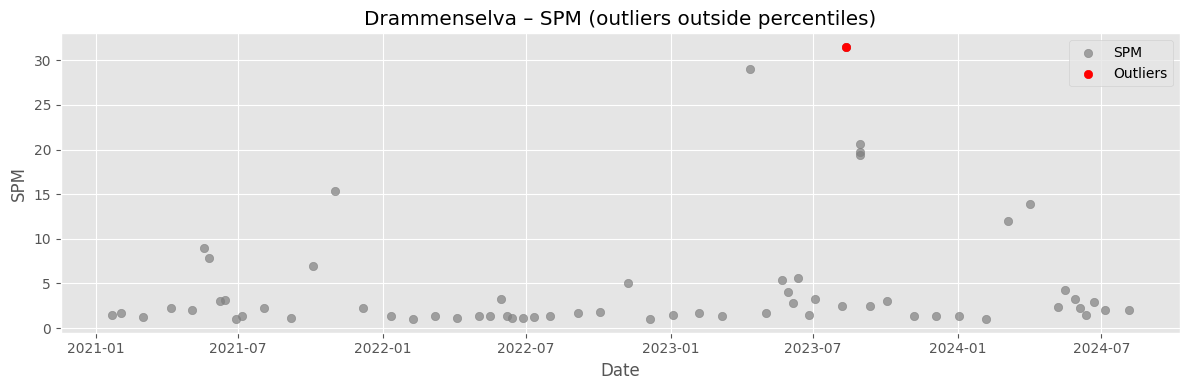

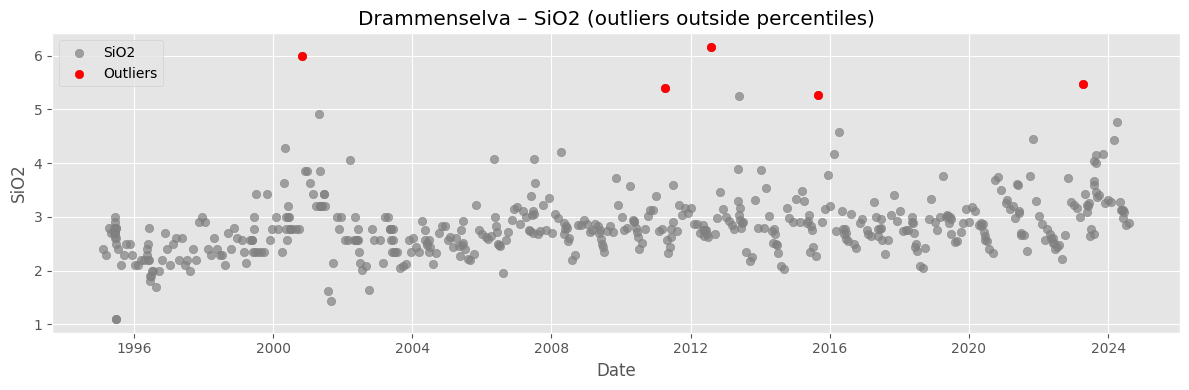

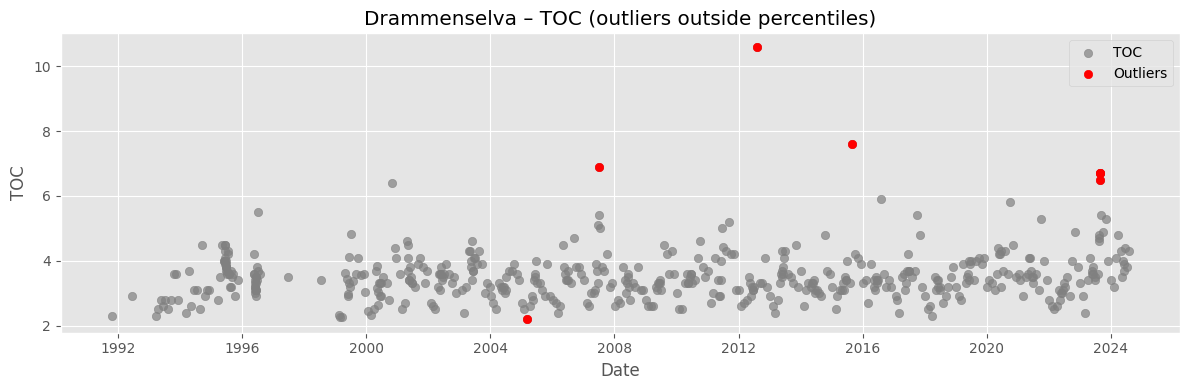

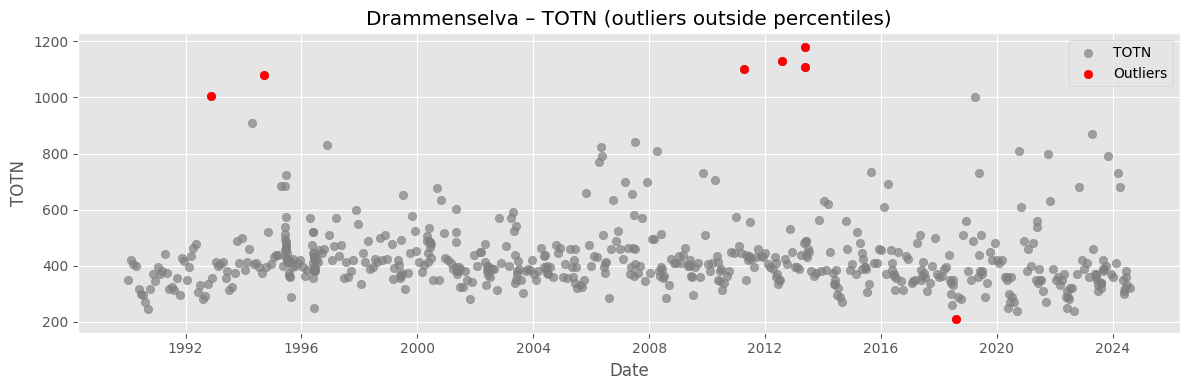

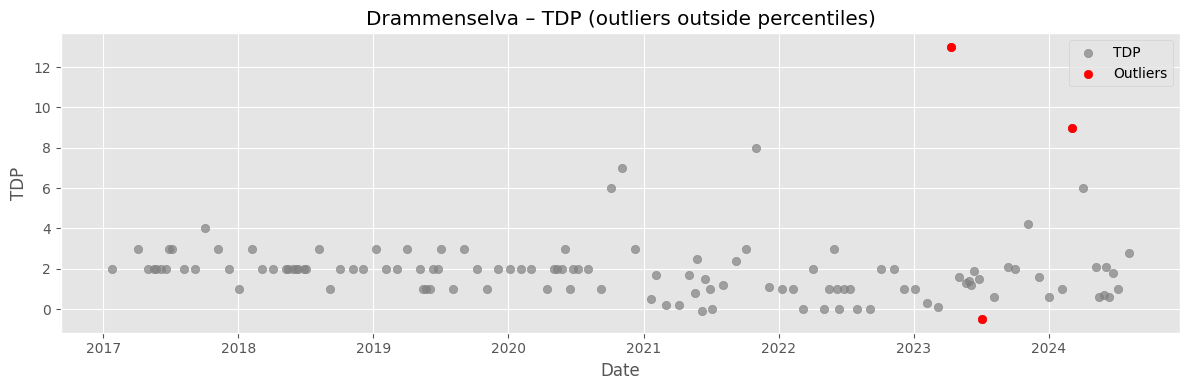

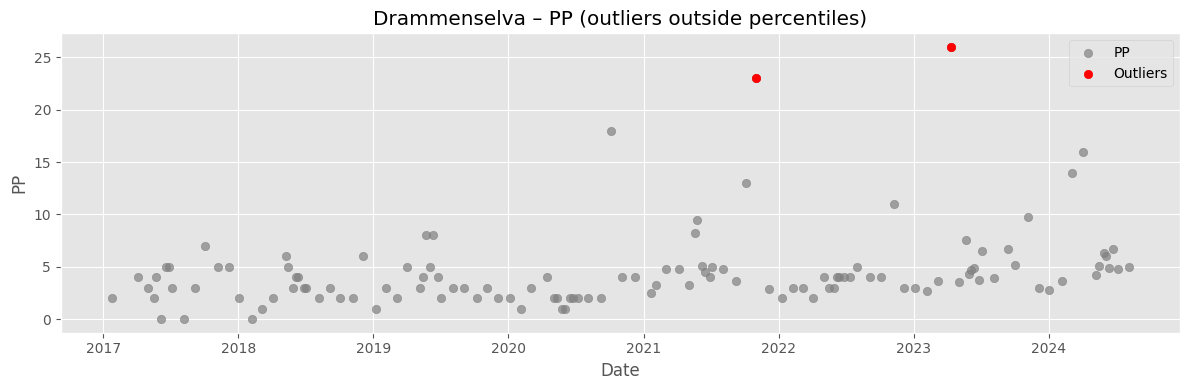

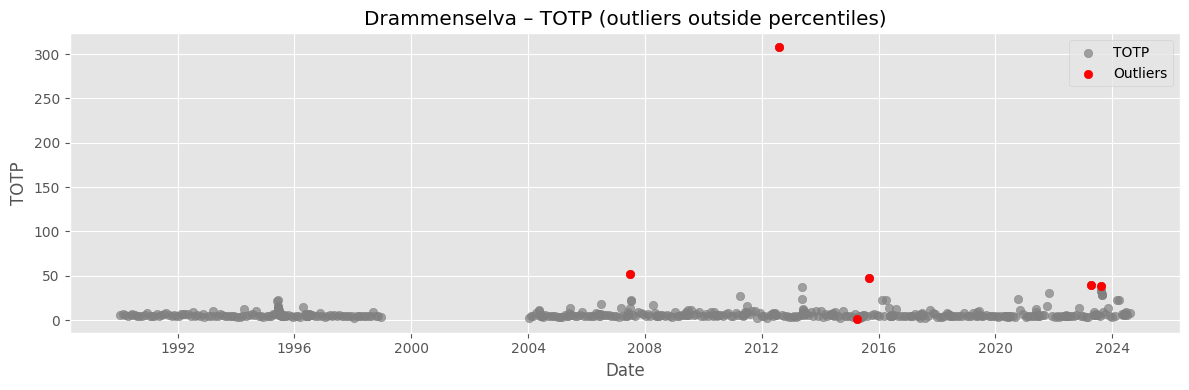

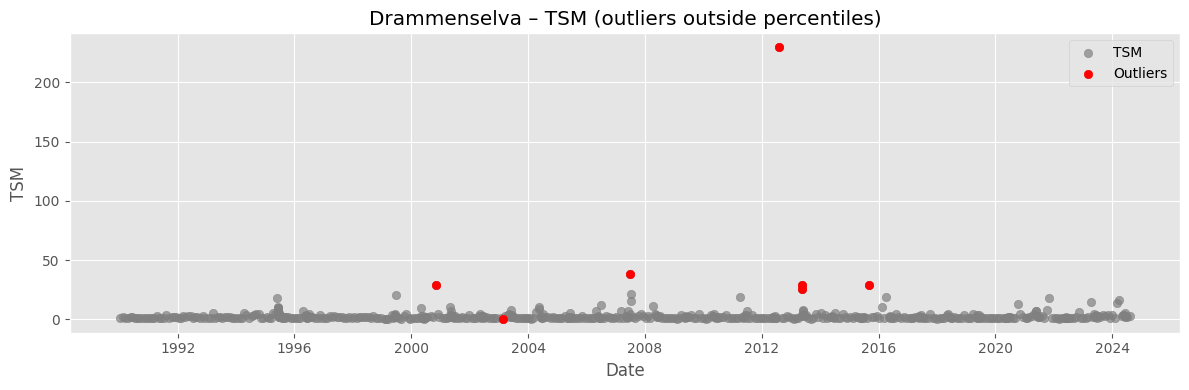

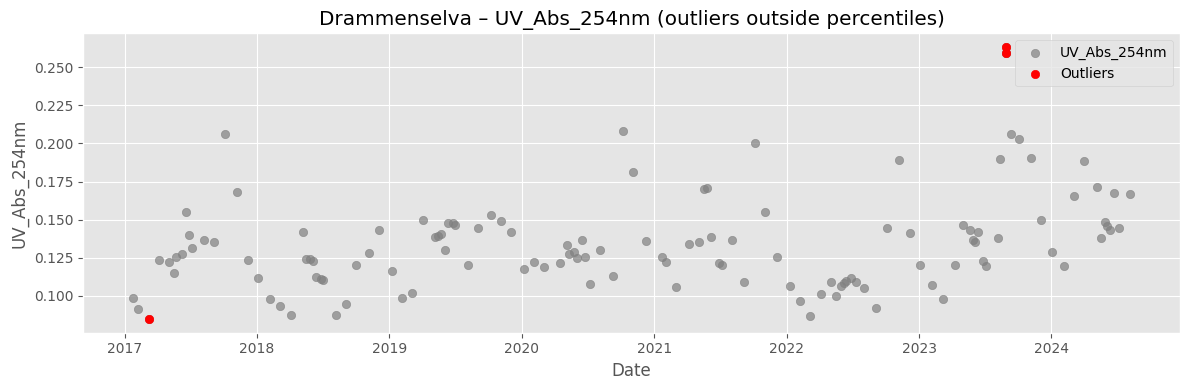

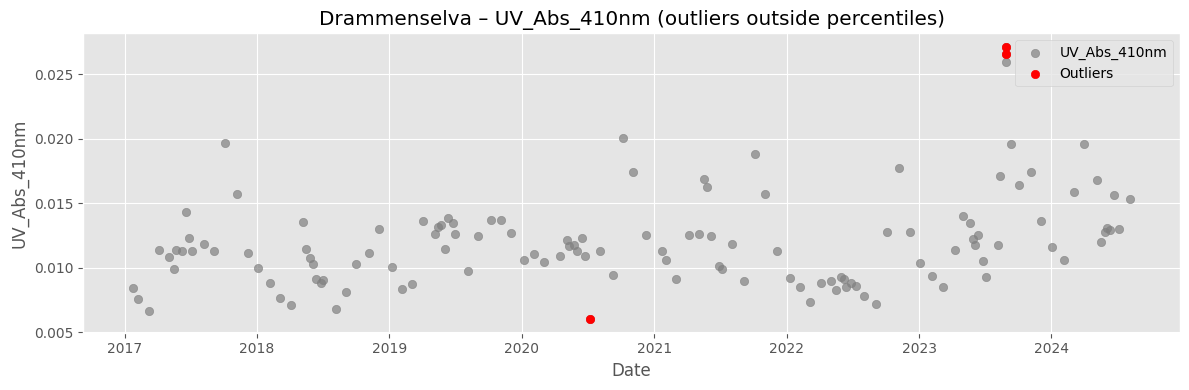

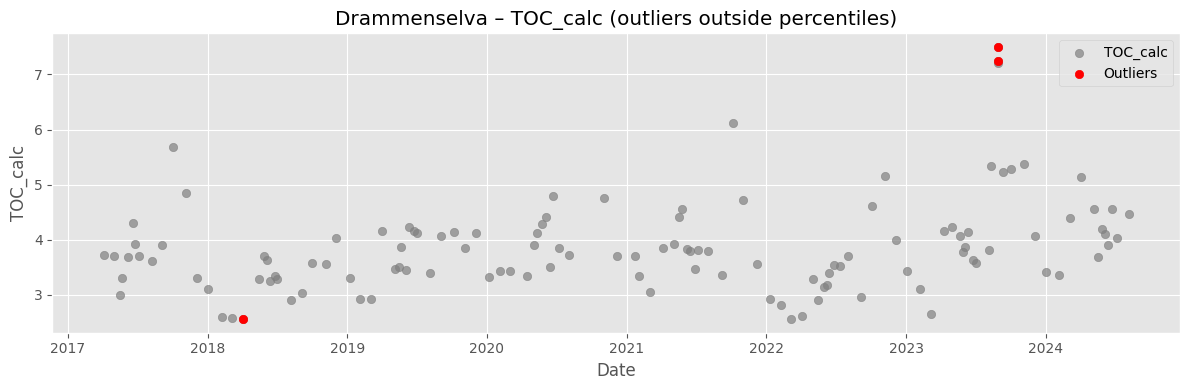

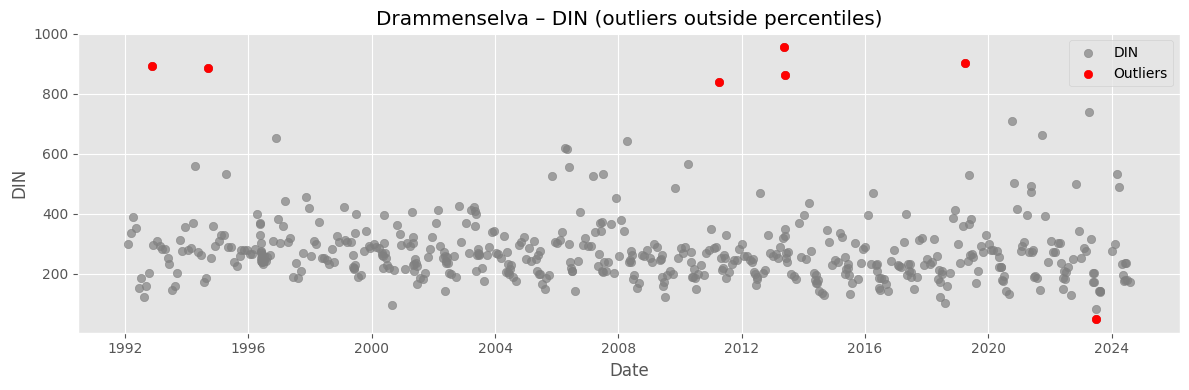

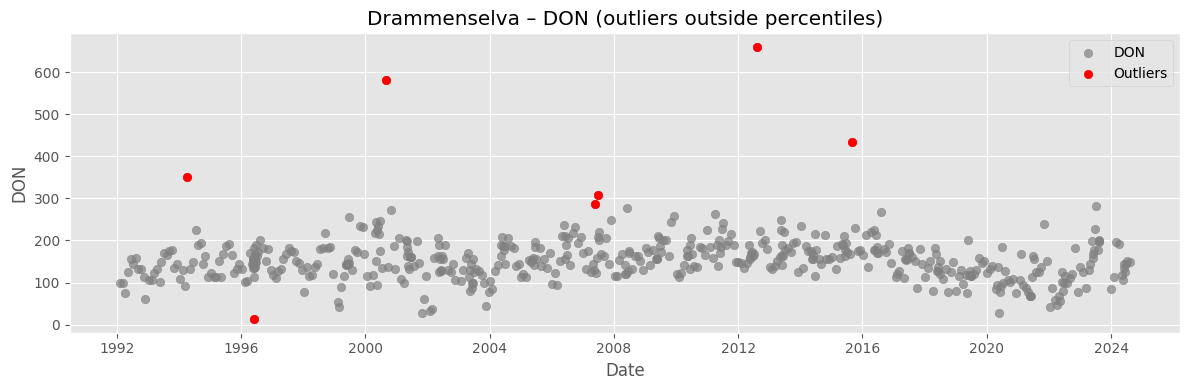

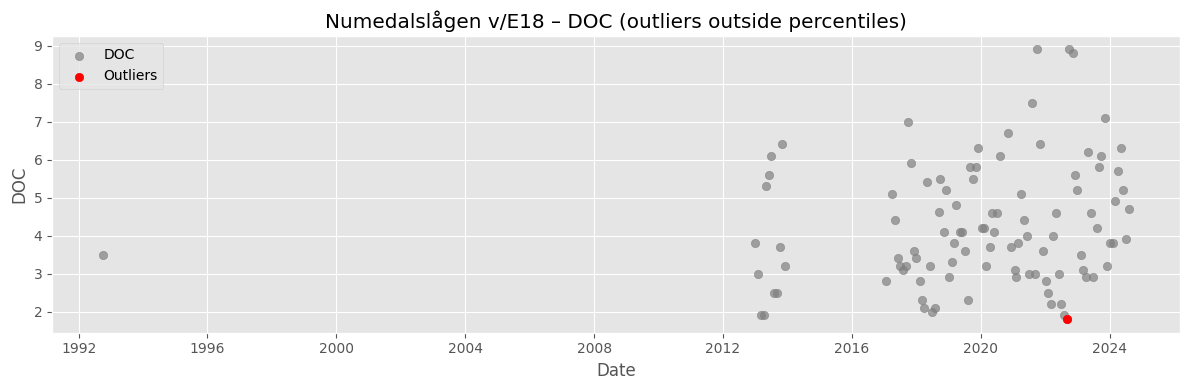

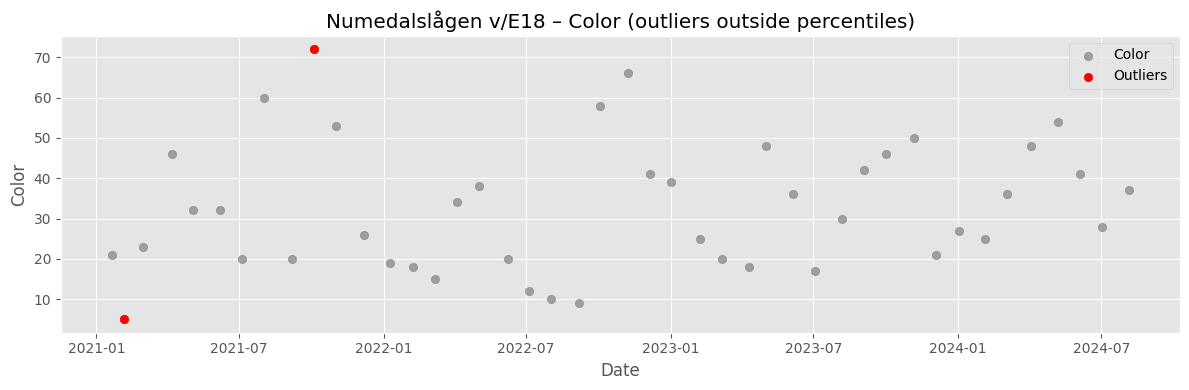

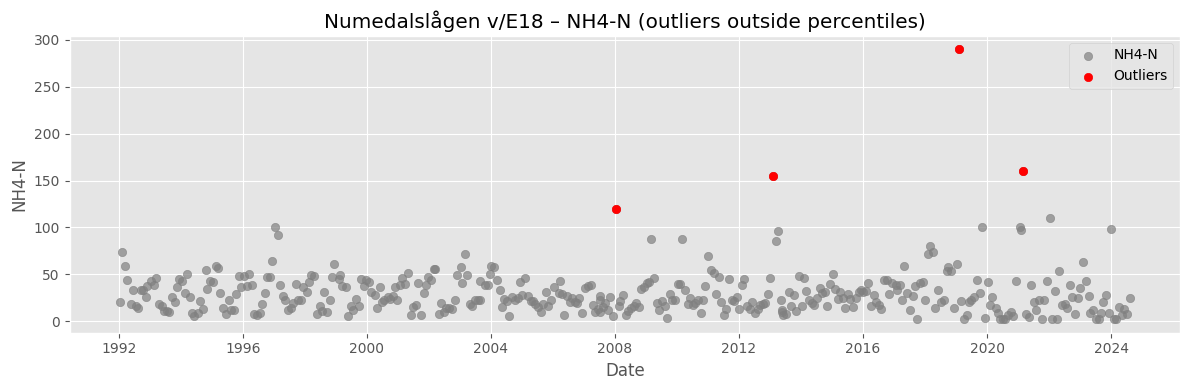

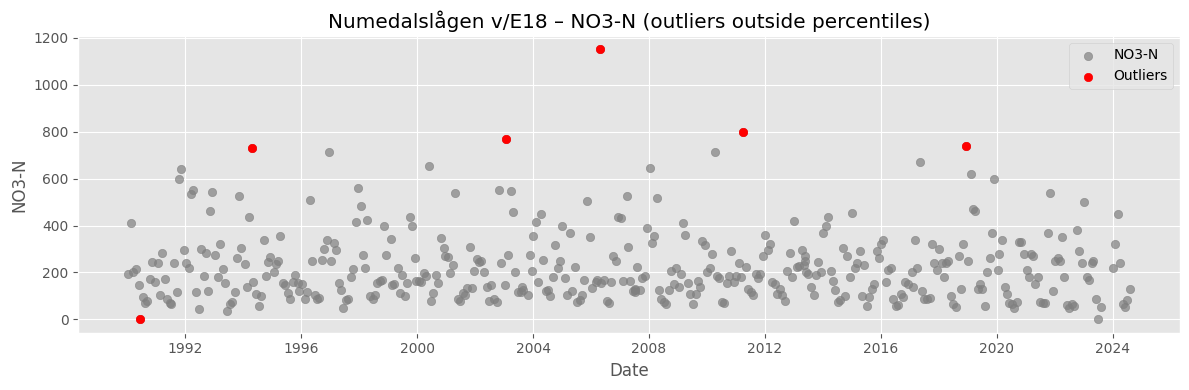

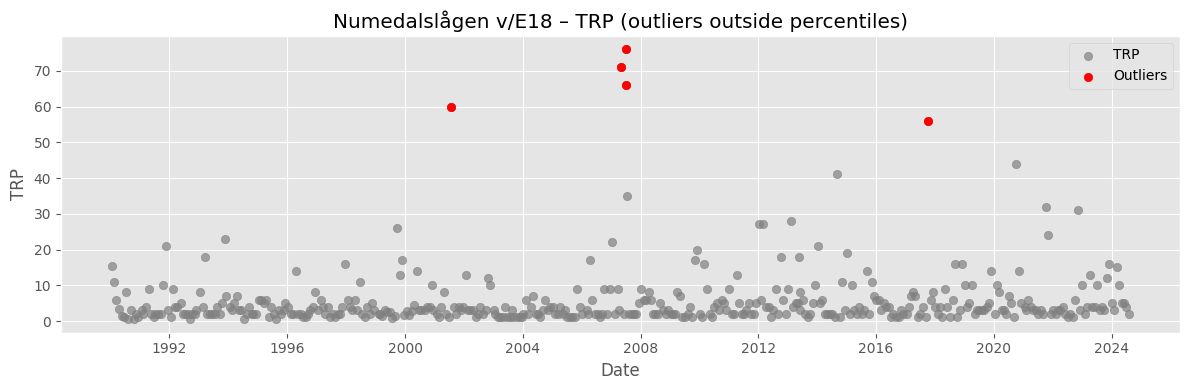

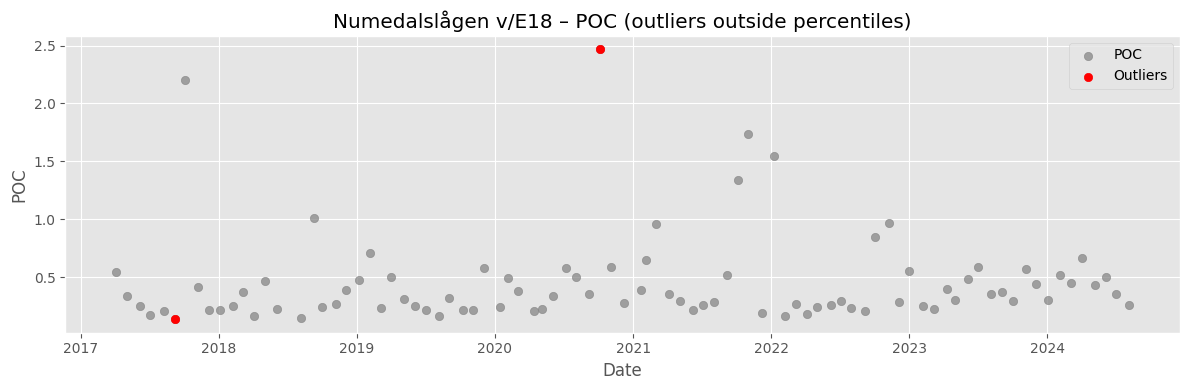

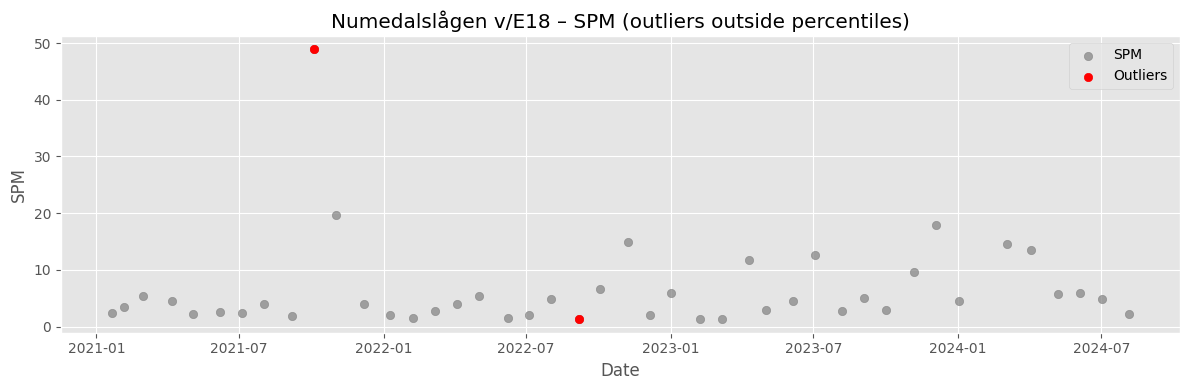

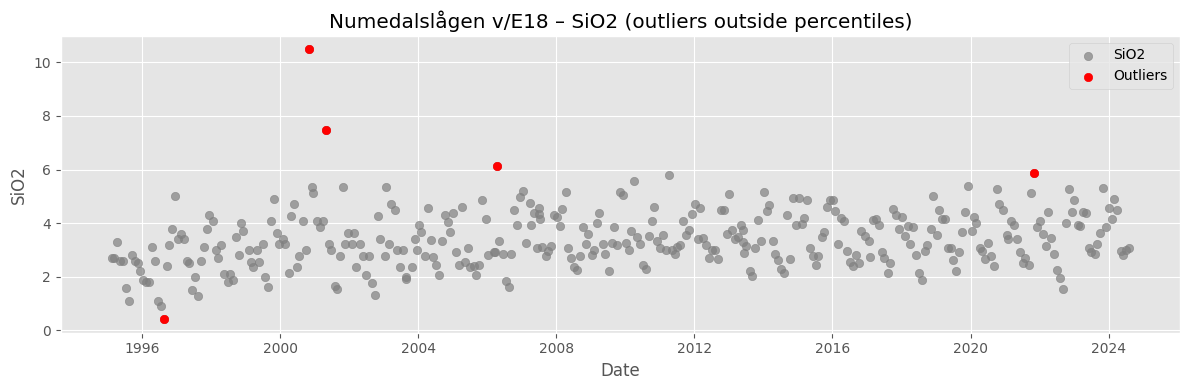

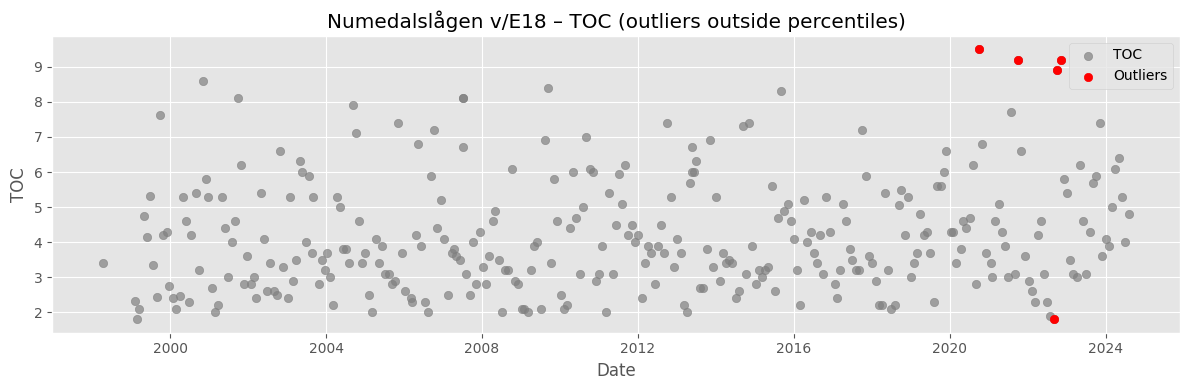

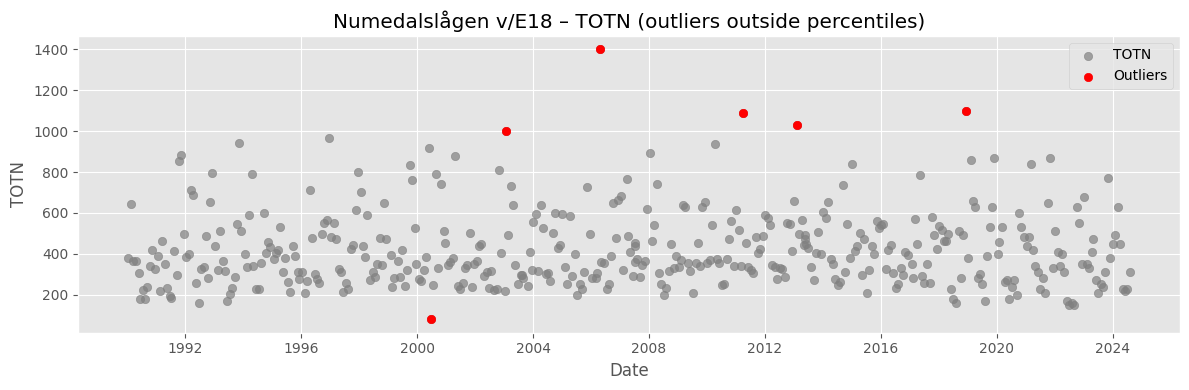

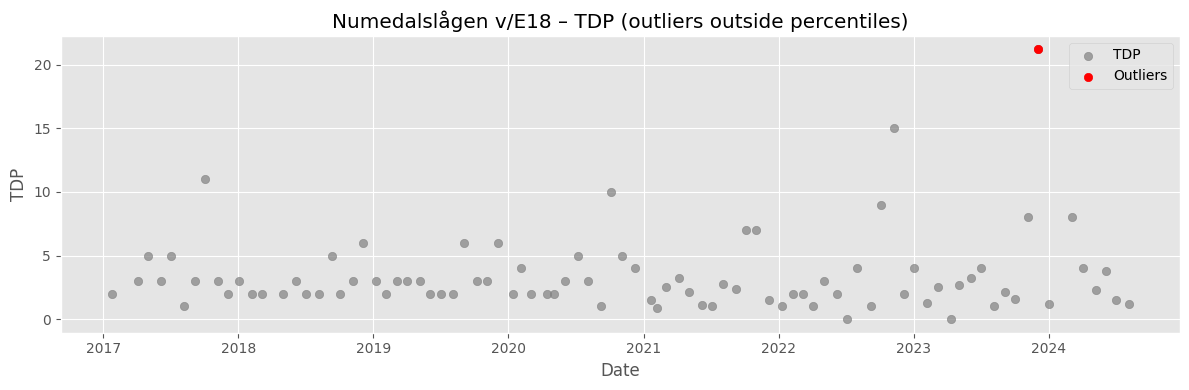

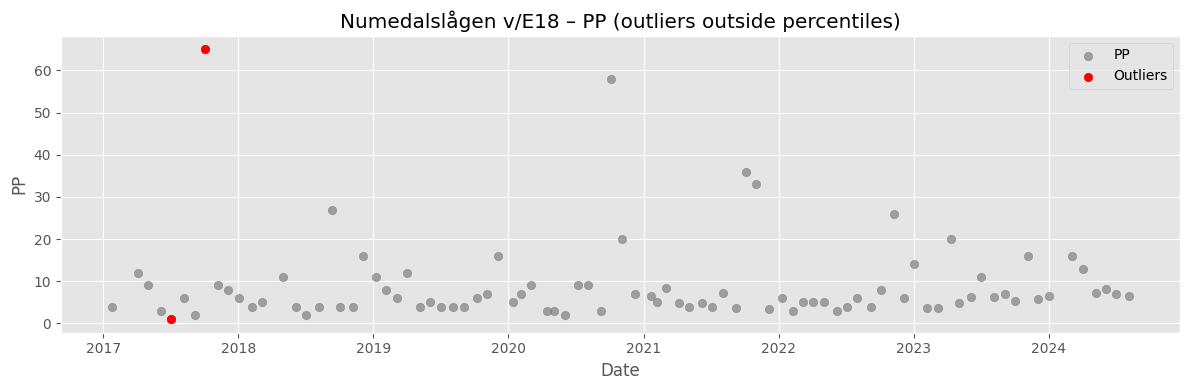

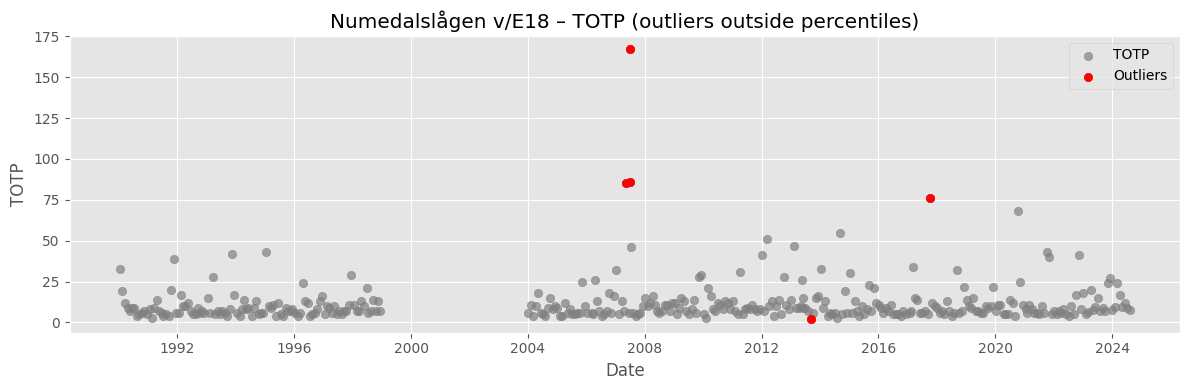

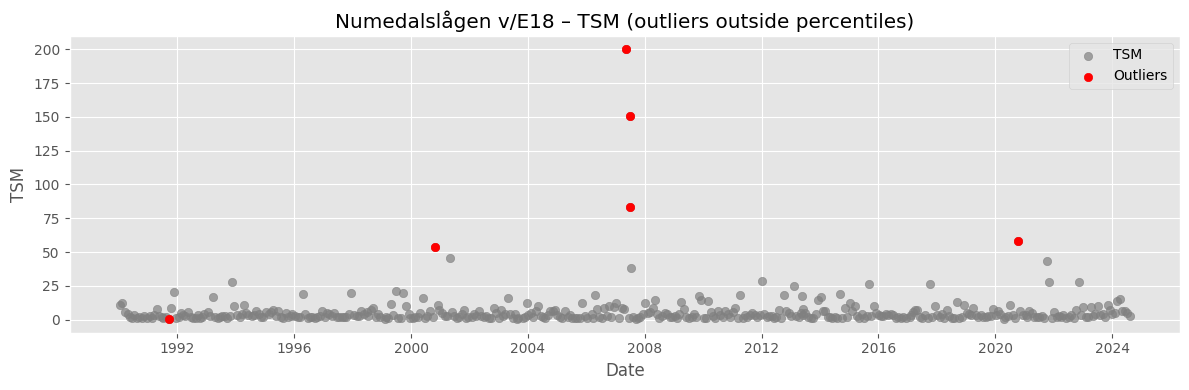

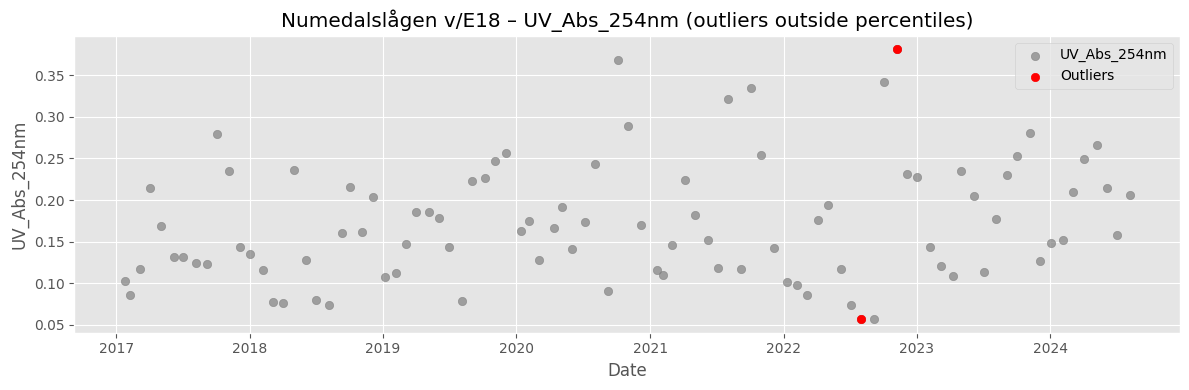

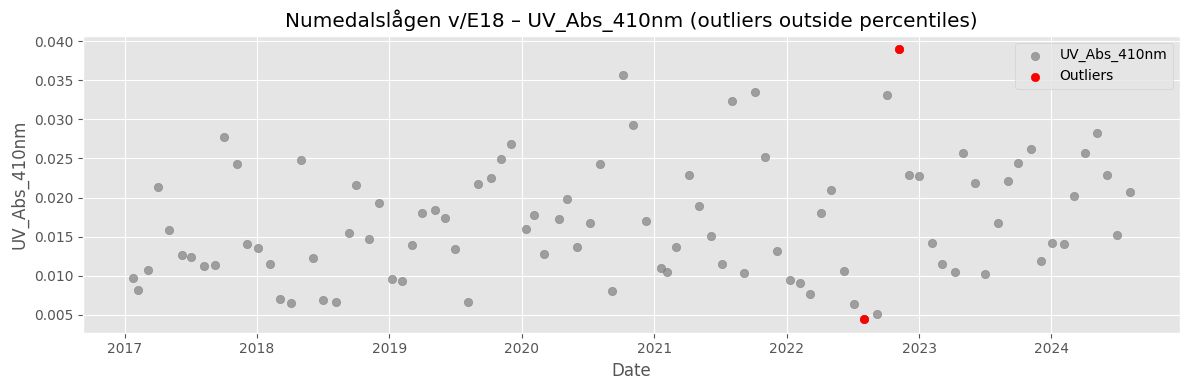

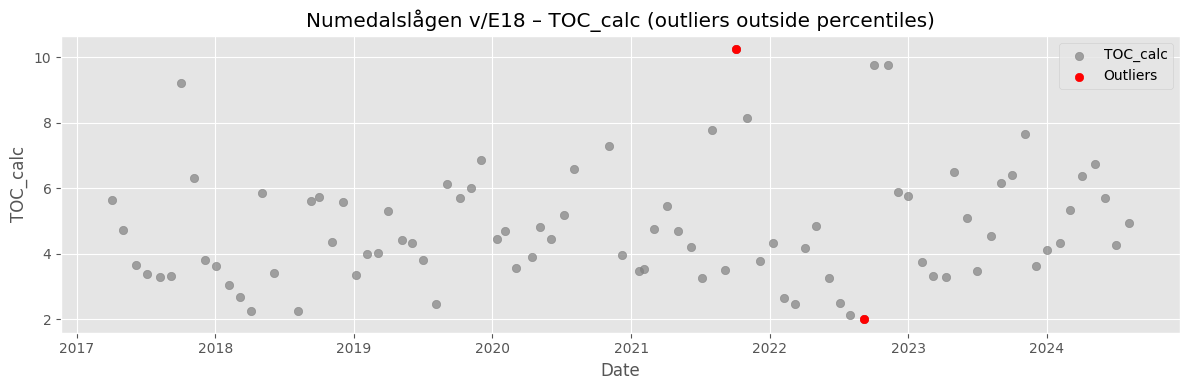

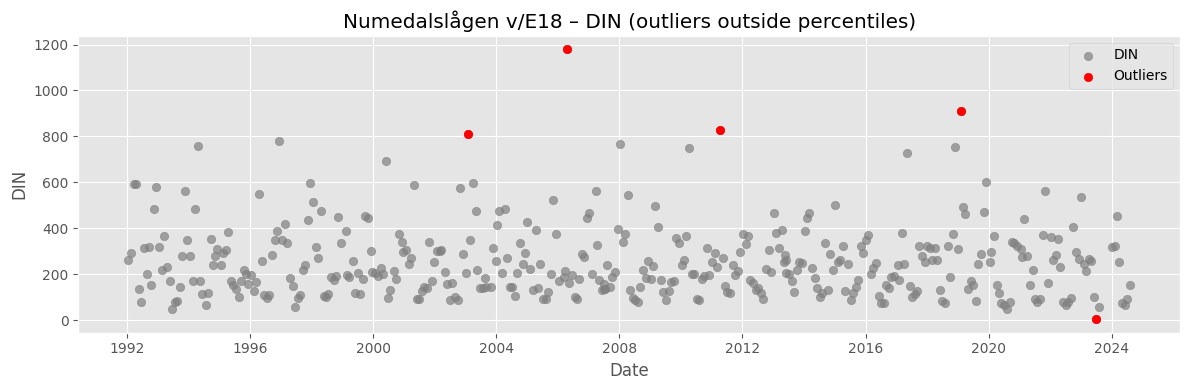

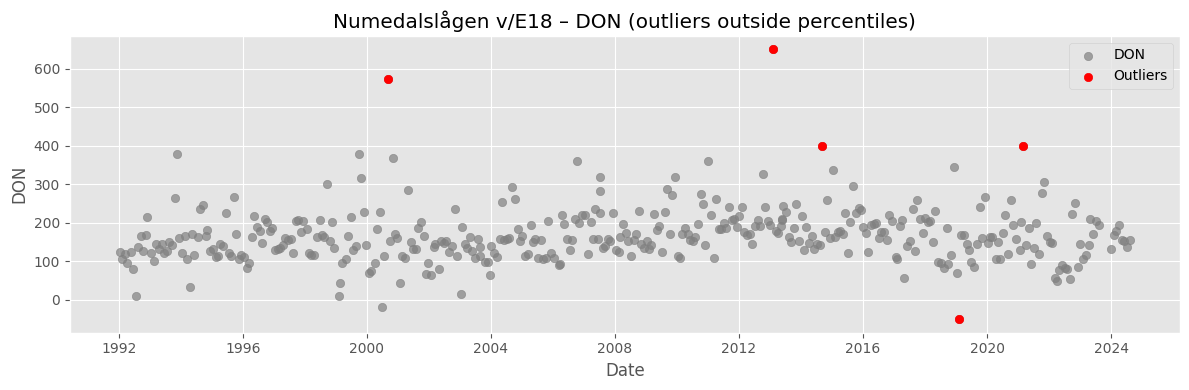

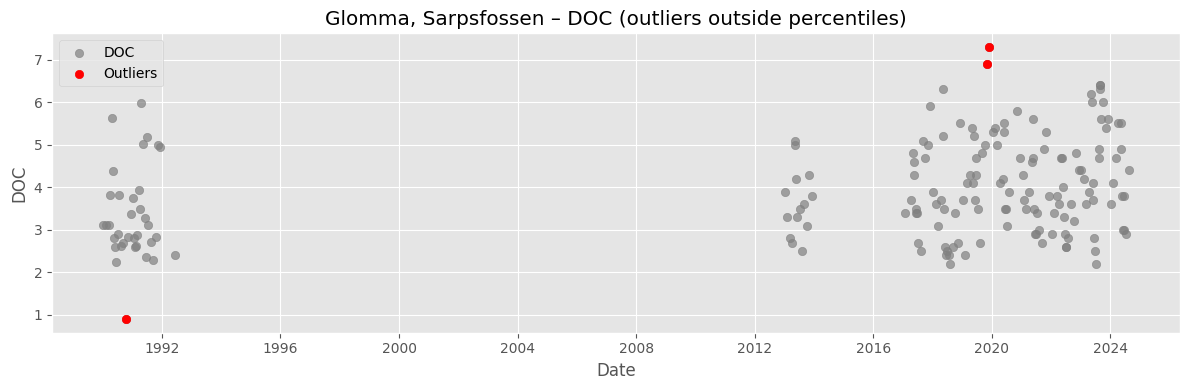

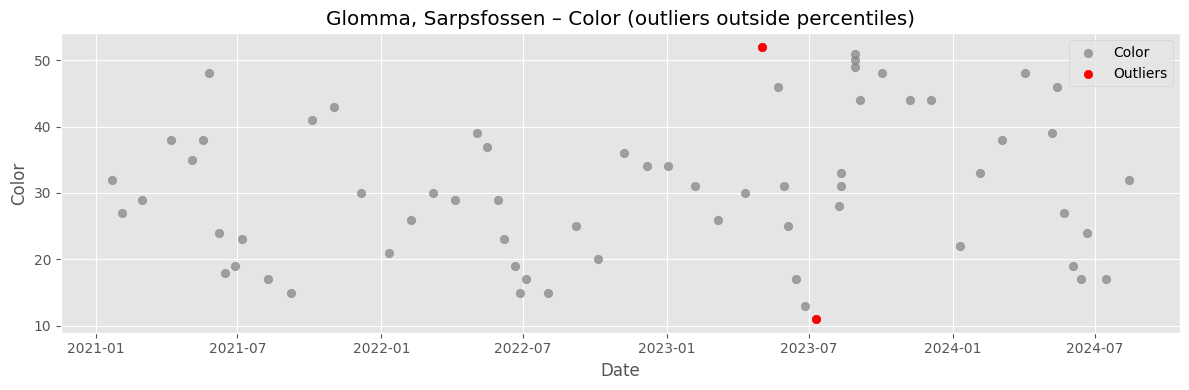

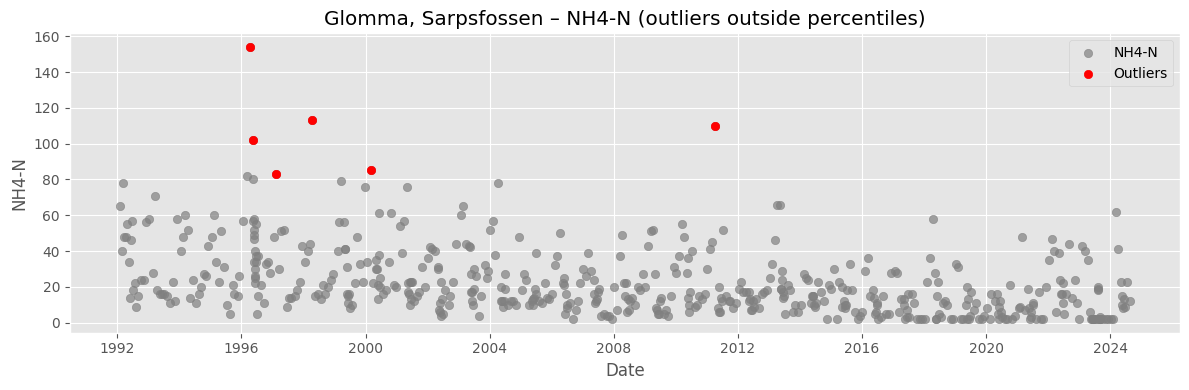

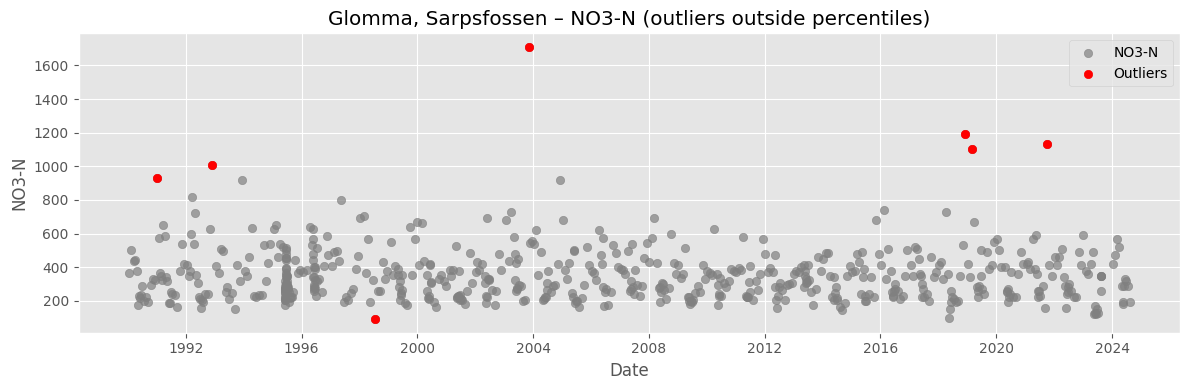

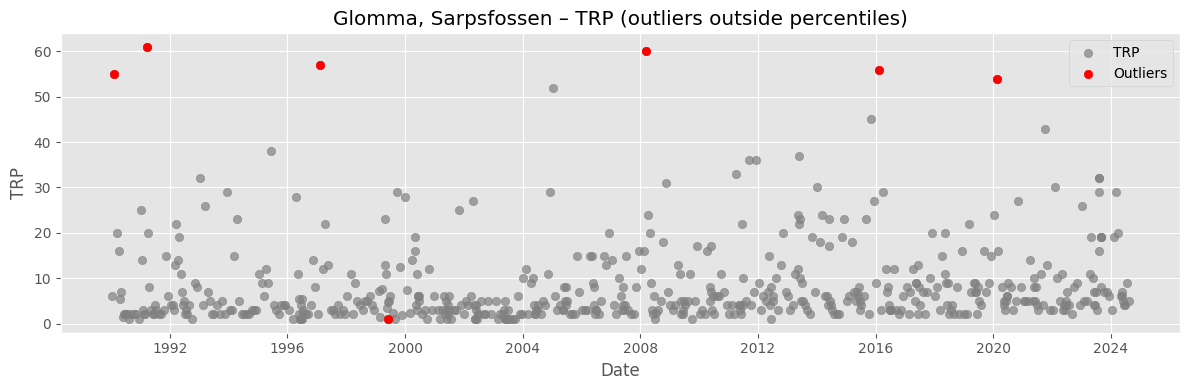

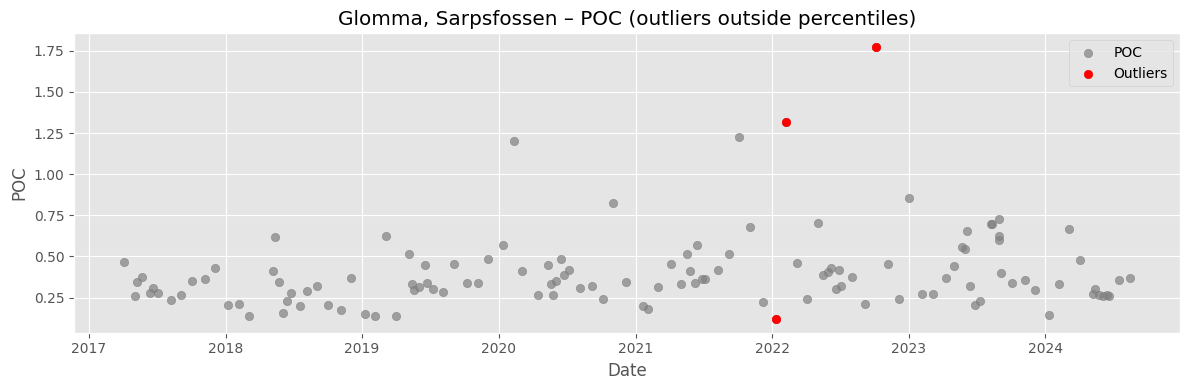

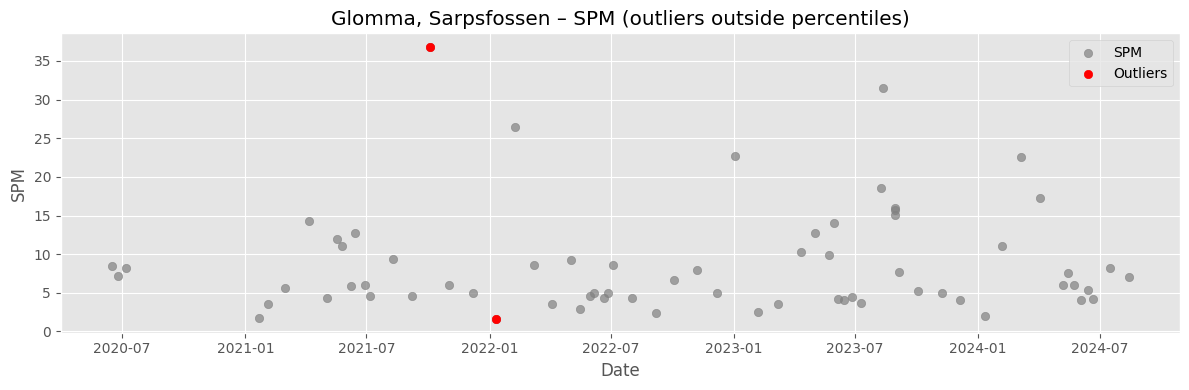

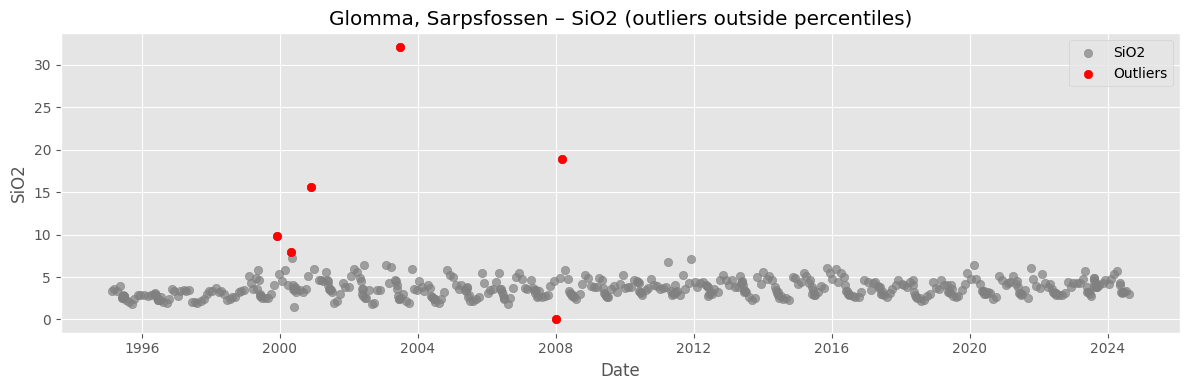

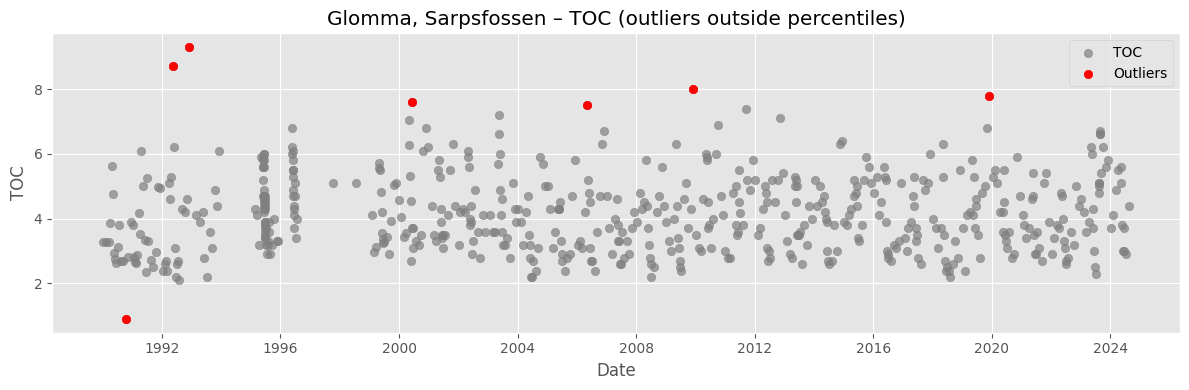

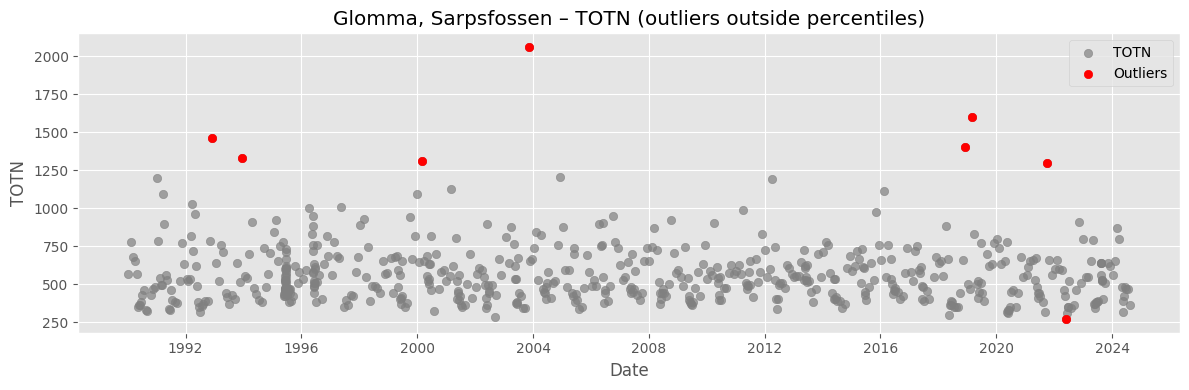

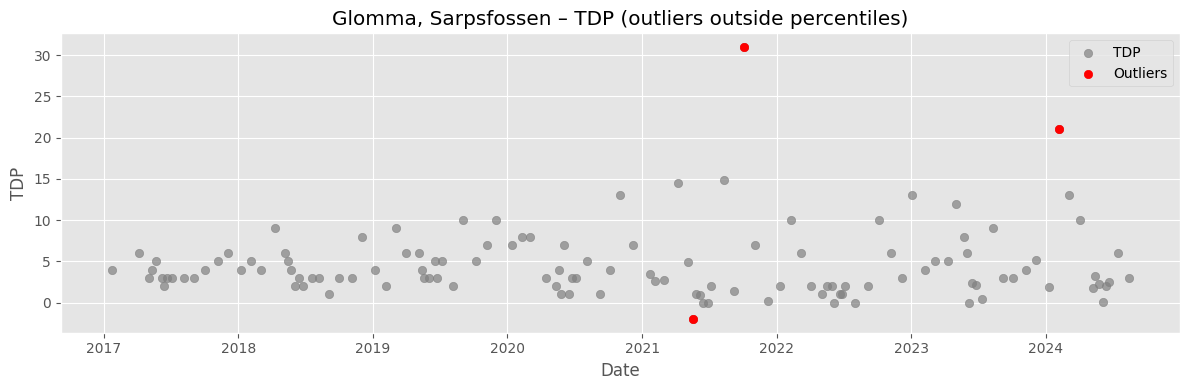

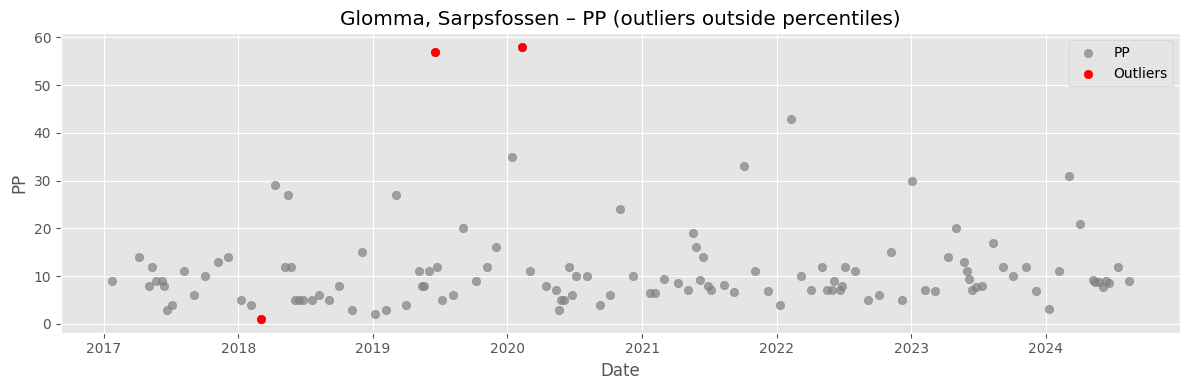

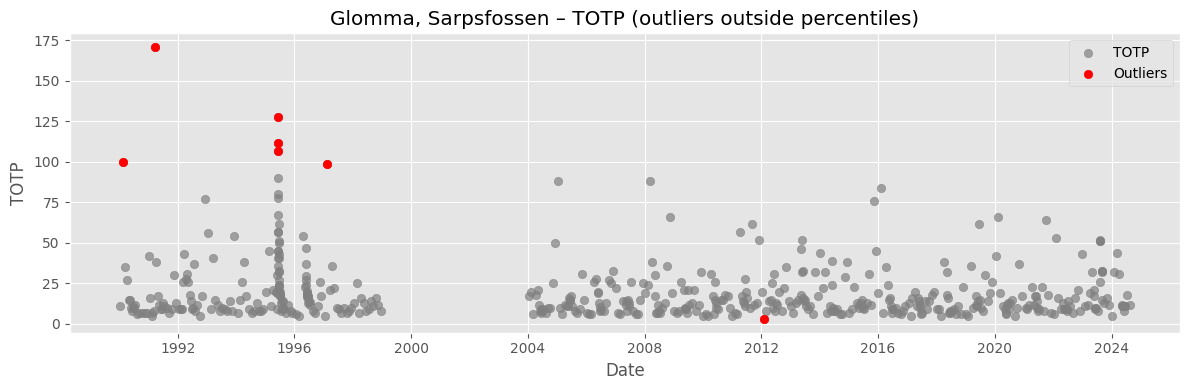

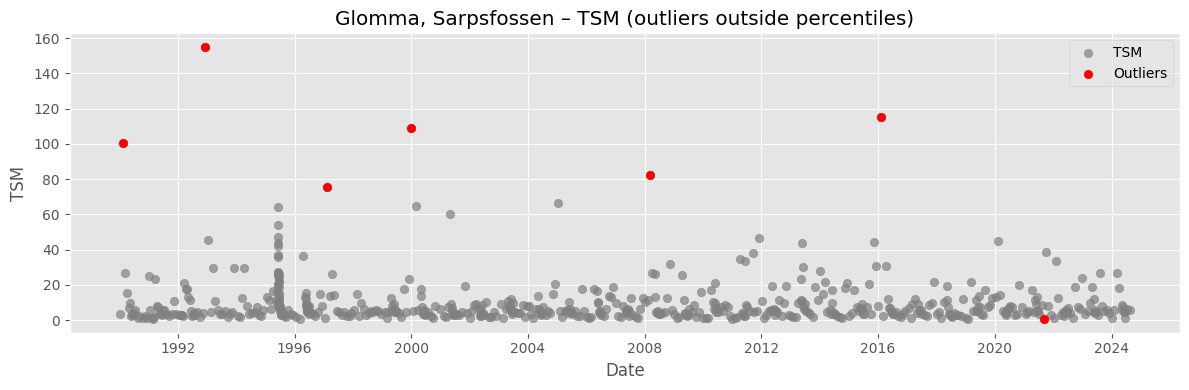

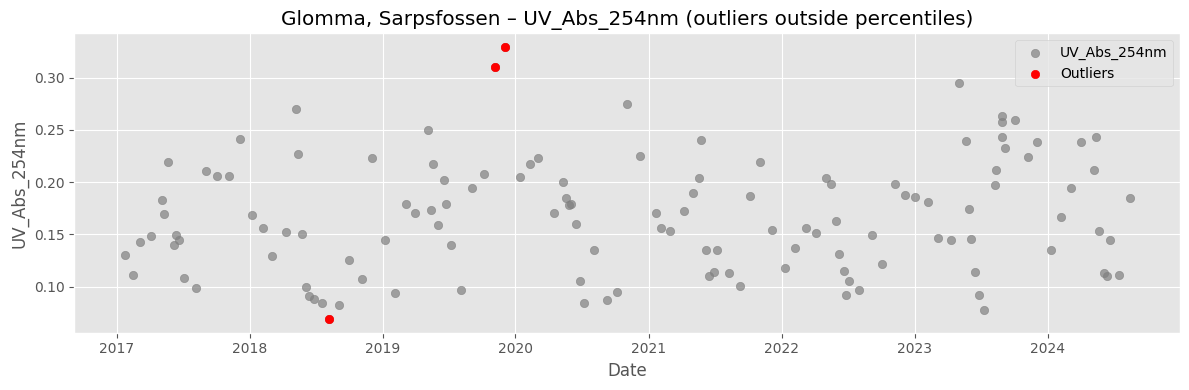

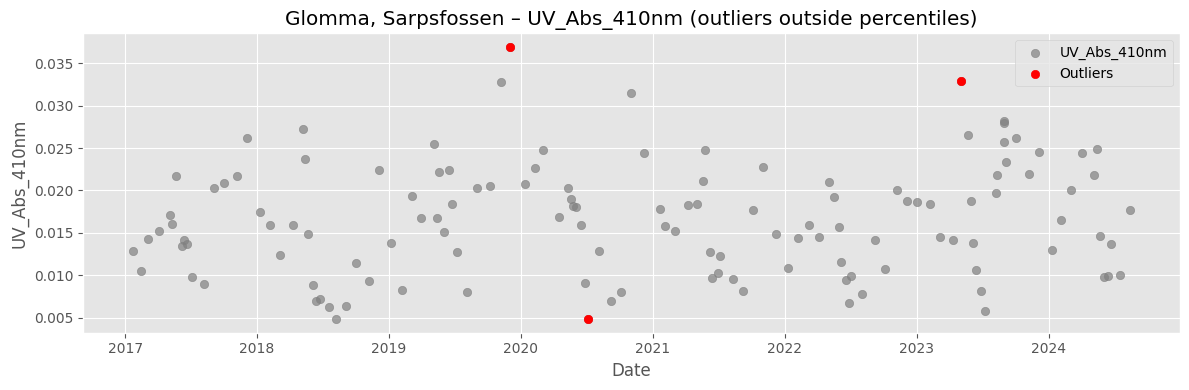

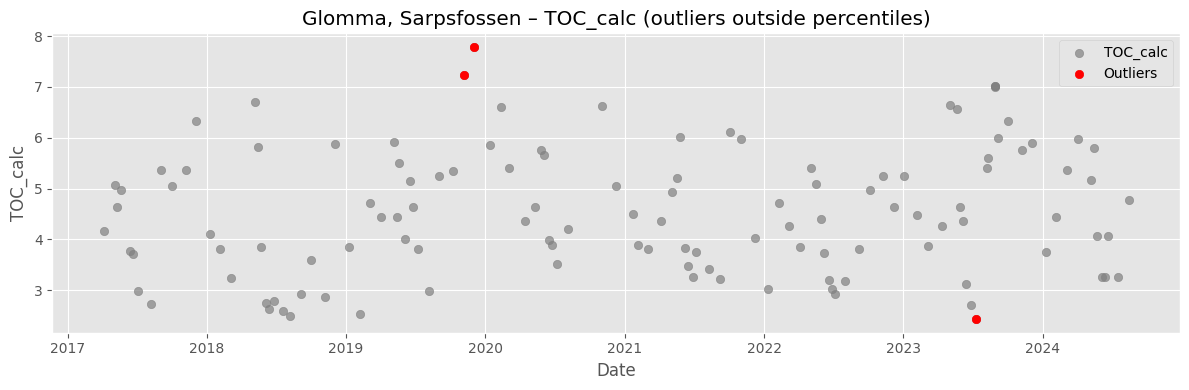

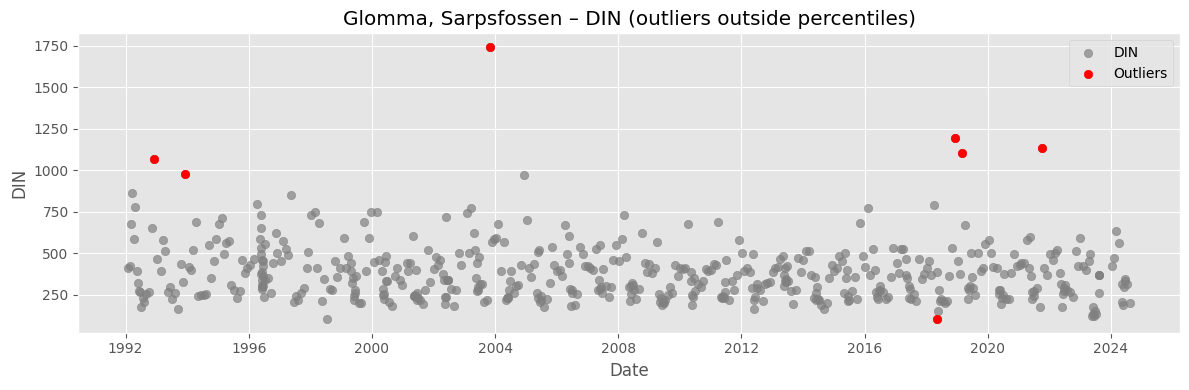

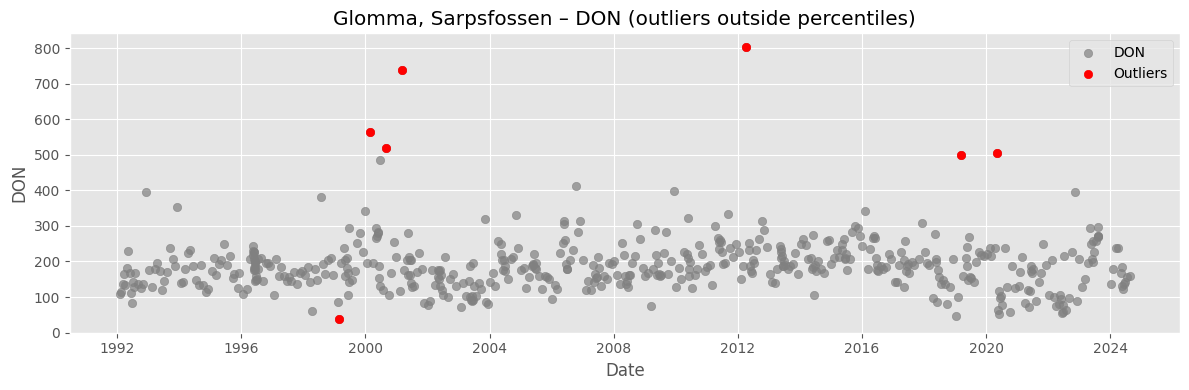

In [9]:
def detect_outliers_per_station(df, station_name, filename, variables=None):
    df = df.copy()
    
    # Automatically detect numeric variables if not specified
    if variables is None:
        variables = [
            col for col in df.columns
            if pd.api.types.is_numeric_dtype(df[col]) and col not in ['station_id', 'depth', 'longitude', 'latitude']
        ]

    for var in variables:
        if var not in df.columns:
            continue

        series = df[var].dropna()
        if series.empty:
            continue

        p5 = series.quantile(0.0005)
        p95 = series.quantile(0.99)
        outliers = (df[var] < p5) | (df[var] > p95)

        # Plotting
        plt.figure(figsize=(12, 4))
        plt.scatter(df['sample_date'], df[var], label=var, color='gray', alpha=0.7)
        plt.scatter(df.loc[outliers, 'sample_date'], df.loc[outliers, var], color='red', label='Outliers')
        plt.title(f"{station_name} – {var} (outliers outside percentiles)")
        plt.xlabel("Date")
        plt.ylabel(var)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Replace outliers with NaN
        df.loc[outliers, var] = np.nan

    return df


cleaned_dataframes = []
for fname, df in derived_dataframes: 
    station_name = df['station_name'].dropna().unique()
    station_str = station_name[0] if len(station_name) else fname
    cleaned_df = detect_outliers_per_station(df, station_str, fname)
    cleaned_dataframes.append((fname, cleaned_df))


## 5. Create datasets and assign metadata and global attributes

In [10]:
datasets = []

for fname, df in cleaned_dataframes:
    df = df.copy()
    
    # Make sure date is datetime
    df["sample_date"] = pd.to_datetime(df["sample_date"])
    df = df.set_index("sample_date")

    # Extract metadata from first row
    lat = float(df["latitude"].iloc[0])
    lon = float(df["longitude"].iloc[0])
    station_id = int(df["station_id"].iloc[0])
    station_code = str(df["station_code"].iloc[0])
    station_name = str(df["station_name"].iloc[0])
    station_type = str(df["station_type"].iloc[0])

    # Remove constant fields from dataframe to avoid them being treated as varying
    df_clean = df.drop(columns=["latitude", "longitude", "station_id", "station_code", "station_name", "station_type"])

    # Convert to xarray dataset
    ds = xr.Dataset.from_dataframe(df_clean)

    # Add attributes to sample date (time coordinate)
    ds = ds.assign_coords(sample_date=("sample_date", df.index))
    ds["sample_date"].attrs.update({"standard_name": "time", "long_name": "Time of measurement", "axis": "T"})

    # Add scalar coordinates
    ds = ds.assign_coords(
        latitude=xr.DataArray(lat, dims=(), attrs={"standard_name": "latitude", "long_name": "latitude", "units": "degree_north"}),
        longitude=xr.DataArray(lon, dims=(), attrs={"standard_name": "longitude", "long_name": "longitude", "units": "degree_east"})
    )
    ds = ds.set_coords(["latitude", "longitude"])

    # Add station info 
    ds["station_id"] = xr.DataArray(station_id, dims=())
    ds["station_code"] = xr.DataArray(station_code, dims=())
    ds["station_name"] = xr.DataArray(station_name, dims=(), attrs={"cf_role": "timeseries_id"})
    ds["station_type"] = xr.DataArray(station_type, dims=())

    # Add metadata to data variables
    for var in ds.data_vars:
        if var in ["station_id", "station_code", "station_name", "station_type"]:
            continue  # skip scalar metadata fields
    
        match = pars_metadata_df[pars_metadata_df["parameter_name"] == var]
    
        if not match.empty:
            row = match.iloc[0]
            ds[var].attrs["units"] = row["unit"]
            ds[var].attrs["parameter_name"] = row["parameter_name"]
            ds[var].attrs["long_name"] = standard_name_map.get(var, row["parameter_name"])
    
            # Assign comments 
            if var in var_comments:
                ds[var].attrs["comment"] = var_comments[var]
                       
    datasets.append((fname, ds))

# Metadata example
datasets[0][1]["TOTN"].attrs

{'units': 'µg/l',
 'parameter_name': 'TOTN',
 'long_name': 'Total Nitrogen',
 'comment': 'TOTN is reconstructed using Eurofins data (TOTN_EF_usikker), which are considered more uncertain than NIVA data. However, due to gaps in NIVA data from 2017–2021, Eurofins measurements were included to ensure completeness.'}

In [12]:
int_encoding = {"dtype": "int32", "_FillValue": -9999}

for fname, ds in datasets:
    # Extract metadata for convenience
    station_name = str(ds["station_name"].values.item())
    station_code = str(ds["station_code"].values.item())
    lat = float(ds["latitude"].values.item())
    lon = float(ds["longitude"].values.item())

    # Assign global attributes
    ds.attrs = dict(
        naming_authority="no.niva",
        title=f"Cleaned water chemistry measurements at station {station_name}",
        title_no=f"Rensede kjemiske målinger ved stasjon {station_name}",
        summary=f"Cleaned long-term water chemistry monitoring at station {station_name} (code: {station_code})",
        summary_no=f"Rensede, langsiktige vannkjemiske målinger ved stasjon {station_name} (kode: {station_code})",
        keywords="GCMDSK:EARTH SCIENCE > WATER QUALITY > CHEMISTRY, GCMDLOC:CONTINENT > EUROPE > NORWAY",
        keywords_vocabulary="GCMDSK:GCMD Science Keywords, GCMDLOC:GCMD Locations",
        iso_topic_category="inlandWaters",
        featureType="timeSeries",
        date_created=datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ"),
        project="AquaINFRA",
        time_coverage_start=np.datetime_as_string(ds.sample_date.min().values, unit="s", timezone="UTC"),
        time_coverage_end=np.datetime_as_string(ds.sample_date.max().values, unit="s", timezone="UTC"),
        geospatial_lat_min=lat,
        geospatial_lat_max=lat,
        geospatial_lon_min=lon,
        geospatial_lon_max=lon,
        spatial_representation="point",
        creator_type="institution",
        creator_institution="Norwegian Institute for Water Research (NIVA)",
        institution="NIVA",
        institution_short_name="NIVA",
        creator_email="areti.balkoni@niva.no",
        creator_url="https://www.niva.no/en/employees/areti-balkoni",
        data_owner="Norwegian Institute for Water Research",
        processing_level="Harmonized and cleaned",
        Conventions="CF-1.7, ACDD-1.3",
        publisher_name="Norwegian Institute for Water Research",
        publisher_email="miljoinformatikk@niva.no",
        publisher_url="https://niva.no",
        license="http://spdx.org/licenses/CC-BY-4.0(CC-BY-4.0)",
        history="Harmonized and cleaned using percentile-based filtering",

        toc_calc_notes=(
        "Lab-reported TOC values may underestimate total organic carbon in turbid samples due to the lack of stirring in the autosampler, "
        "causing particles to settle."
        "TOC and DOC are rounded to 0.1 mg/L, adding further uncertainty, while POC is reported to the nearest µg/L. "
        "Therefore, TOC_calc (POC + DOC) is often more reliable than lab-reported TOC, but all results should be interpreted considering analytical uncertainties."
        )
    )

    # Set encoding dictionary
    encoding = {
        "sample_date": {
            "dtype": "int32",
            "_FillValue": None,
            "units": "seconds since 1970-01-01 00:00:00",
        },
        "longitude": {"_FillValue": None},
        "latitude": {"_FillValue": None},
    }

    if "station_id" in ds:
        encoding["station_id"] = int_encoding

    # Define file name
    station_id = int(ds["station_id"].values.item())
    output_path = output_dir / f"cleaned_riverchem_{station_id}_{datetime.now().strftime('%d-%m-%Y')}.nc"

    # Save NetCDF file
    ds.to_netcdf(output_path, encoding=encoding)

    print(f"Saved NetCDF: {output_path}")

Saved NetCDF: ..\..\data\river\water_chemistry\cleaned\cleaned_riverchem_40352_19-06-2025.nc
Saved NetCDF: ..\..\data\river\water_chemistry\cleaned\cleaned_riverchem_40355_19-06-2025.nc
Saved NetCDF: ..\..\data\river\water_chemistry\cleaned\cleaned_riverchem_40356_19-06-2025.nc
